# ACTIVIDAD : Redes Convolucionales

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes los Simpsons.

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de la serie extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/)
Partiendo de los 18 personajes etiquetados, éstos pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
## Librerías utilizadas
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import shutil
from PIL import Image
from torchvision import transforms
import random
from tqdm import tqdm


import cv2
import os
import numpy as np
import os
import torch
# import keras
# from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import kagglehub
import shutil
import random
from sklearn.model_selection import train_test_split

Nos descargamos la carpeta de la web de Kaggle:
https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download&select=simpsons_dataset

In [2]:
## Descargar dataset
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")
print("Descargado en:", path)

## Definir rutas
source_path = os.path.join(path, "simpsons_dataset")
target_path = "./simpsons_dataset"

## Si ya existe, eliminar y copiar de nuevo
if os.path.exists(target_path):
    shutil.rmtree(target_path)
    print(f"⚠️ Carpeta existente eliminada: {target_path}")

shutil.copytree(source_path, target_path)
print(f"✅ Dataset copiado a: {target_path}")

100%|██████████| 1.08G/1.08G [00:07<00:00, 153MB/s]

Extracting files...


Descargado en: /root/.cache/kagglehub/datasets/alexattia/the-simpsons-characters-dataset/versions/4
✅ Dataset copiado a: ./simpsons_dataset


Podemos ver que los personajes están repartidos en carpetas

In [3]:
# ## Los personajes se encuentran en carpetas
# !ls $path/simpsons_dataset


In [4]:
dataset_dir = target_path
conteo_imagenes = {}

for cls in sorted(os.listdir(dataset_dir)):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        imagenes = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
        conteo_imagenes[cls] = len(imagenes)

## Mostrar resultados ordenados
for cls, count in sorted(conteo_imagenes.items(), key=lambda x: x[1]):
    print(f"{cls:30s} -> {count} imágenes")

simpsons_dataset               -> 0 imágenes
lionel_hutz                    -> 3 imágenes
disco_stu                      -> 8 imágenes
troy_mcclure                   -> 8 imágenes
miss_hoover                    -> 17 imágenes
fat_tony                       -> 27 imágenes
gil                            -> 27 imágenes
otto_mann                      -> 32 imágenes
sideshow_mel                   -> 40 imágenes
agnes_skinner                  -> 42 imágenes
rainier_wolfcastle             -> 45 imágenes
cletus_spuckler                -> 47 imágenes
snake_jailbird                 -> 55 imágenes
professor_john_frink           -> 65 imágenes
martin_prince                  -> 71 imágenes
patty_bouvier                  -> 72 imágenes
ralph_wiggum                   -> 89 imágenes
carl_carlson                   -> 98 imágenes
selma_bouvier                  -> 103 imágenes
barney_gumble                  -> 106 imágenes
groundskeeper_willie           -> 121 imágenes
maggie_simpson                 -> 1

Como Lionel solo tiene tres imágenes, lo quitamos del entrenamiento

In [5]:
# !rm -r ./simpsons_dataset/lionel_hutz

In [6]:
import shutil

shutil.rmtree("./simpsons_dataset/lionel_hutz")
shutil.rmtree("./simpsons_dataset/simpsons_dataset")

Ahora generaremos diferentes carpetas separando los datos de train, test y validación

In [7]:
## Definimos los paths
ORIGINAL_DATASET_DIR = './simpsons_dataset'
BASE_OUTPUT_DIR = './simpsons_split_dataset'

## Porcentajes; he optado por generar sets de train, test y validación.
## Pero podéis variar los porcentajes
train_pct = 0.7
val_pct = 0.15
test_pct = 0.15

# Limpiar estructura previa si existe - NUEVO
if os.path.exists(BASE_OUTPUT_DIR):
    shutil.rmtree(BASE_OUTPUT_DIR)

## Crear estructura de carpetas
splits = ['train', 'val', 'test']
classes = os.listdir(ORIGINAL_DATASET_DIR)
classes = [cls for cls in classes if os.path.isdir(os.path.join(ORIGINAL_DATASET_DIR, cls))]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, cls), exist_ok=True)

## Dividir y copiar imágenes
for cls in classes:
    cls_path = os.path.join(ORIGINAL_DATASET_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
    random.shuffle(images)

    # Asignación predeterminada
    train, val, test = [], [], []

    if len(images) >= 3:
        train, temp = train_test_split(images, train_size=train_pct, random_state=42)
        val, test = train_test_split(temp, test_size=test_pct / (test_pct + val_pct), random_state=42)
    else:
        # Si hay muy pocas imágenes, lo mandamos todo al entrenamiento
        train = images
        print(f"[Aviso] Clase '{cls}' tiene muy pocas imágenes ({len(images)}). Se asignan todas a entrenamiento.")

    for img_list, split in zip([train, val, test], ['train', 'val', 'test']):
        for img in img_list:
            src = os.path.join(cls_path, img)
            dst = os.path.join(BASE_OUTPUT_DIR, split, cls, img)
            shutil.copyfile(src, dst)

In [8]:
## Crear diccionario de mapeo automáticamente
MAP_CHARACTERS = {i: cls for i, cls in enumerate(sorted(classes))}
MAP_CHARACTERS

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lisa_simpson',
 20: 'maggie_simpson',
 21: 'marge_simpson',
 22: 'martin_prince',
 23: 'mayor_quimby',
 24: 'milhouse_van_houten',
 25: 'miss_hoover',
 26: 'moe_szyslak',
 27: 'ned_flanders',
 28: 'nelson_muntz',
 29: 'otto_mann',
 30: 'patty_bouvier',
 31: 'principal_skinner',
 32: 'professor_john_frink',
 33: 'rainier_wolfcastle',
 34: 'ralph_wiggum',
 35: 'selma_bouvier',
 36: 'sideshow_bob',
 37: 'sideshow_mel',
 38: 'snake_jailbird',
 39: 'troy_mcclure',
 40: 'waylon_smithers'}

## Ejercicio

Utilizando Convolutional Neural Networks, entrenar al menos dos clasificadores que sean capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **90%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos, pero cuánta más información podáis aportar mejor a la hora de desarrollar vuestro modelo):

*   Análisis de los datos a utilizar. ¿Qué distribución siguen? ¿Están las clases balanceadas?
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected (sin convolución) para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.


Notas:
* Los datos están en una única carpeta, por lo que tendrás que hacer el split entre train y test
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo de al menos los dos mejores modelos obtenidos y la evaluación de los datos de test con estos modelos**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más sencillas de identificar, por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Feedback 2 - Entregable

## Preparacion de los datos

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Se especifican las rutas de las carpetas creadas para el train, test y validation

In [10]:
# 📍 Rutas a tus carpetas
train_dir = "./simpsons_split_dataset/train"
val_dir = "./simpsons_split_dataset/val"
test_dir = "./simpsons_split_dataset/test"

Se especifican ajustes (transformaciones) que se quieren realizar una vez se carguen los datasets:

- Resize (Necesario): Redimensiona todas las imágenes a 64×64 píxeles (Las CNNs requieren que todas las imágenes tengan el mismo tamaño, de esta manera se asegura)
- ToTensor (Necesario): Convierte la imagen PIL o NumPy en un tensor PyTorch de forma (C, H, W) y normaliza a [0, 1]
- Normalize (Opcional): Normaliza los valores de cada canal de la imagen (Practica comun para que todo funcione mejor). Como viene despues de ToTensor cambia [0,1] a [-1,1]

In [11]:
# 🔄 Transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Redimensiona todas las imágenes a 64x64 píxeles.
    transforms.ToTensor(),                # Convierte la imagen en un tensor PyTorch y normaliza a [0, 1].
    transforms.Normalize([0.5], [0.5])    # Normaliza los valores de cada canal a un rango de [-1, 1].
])

Se cargan los datasets, con las rutas especificadas y con los ajustes o transformaciones definidas. Cada dataset tendra elementos de la forma (img_tensor, etiqueta), donde img_tensor es un tensor de 3 dimensiones con forma (C, H, W):

- C: número de canales (3 para RGB)
- H: altura de la imagen (por ejemplo, 64)
- W: ancho de la imagen (por ejemplo, 64)

In [12]:
# 📂 Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# 🧾 Clases
print("Clases detectadas:", train_dataset.classes) # para comprobar que se han cargado correctamente

Clases detectadas: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


Por entender mejor la estructura de los datos, vamos a ver un ejemplo en detalle. Si hacemos:

img_tensor, etiqueta = train_dataset[0]

tenemos img_tensor un tensor 3D de dimensiones (3, 64, 64) y una etiqueta por ejemplo 0 que representa "abraham_grampa_simpson". En otras palabras:

- img_tensor[0]: matriz (64,64) con información del canal rojo
- img_tensor[1]: matriz (64,64) con información del canal verde
- img_tensor[2]: matriz (64,64) con información del canal azul

Que al combinarlos se genera el tensor (3, 64, 64)

Tamaño tensor: torch.Size([3, 64, 64])
Etiqueta: 0
Visualizacion numerica de ejemplo del canal rojo:
 tensor([[-0.2392, -0.2392, -0.2392,  ...,  0.0902,  0.0824,  0.0510],
        [-0.2235, -0.2235, -0.2235,  ...,  0.1059,  0.0431,  0.0353],
        [-0.2235, -0.2235, -0.2157,  ...,  0.0510,  0.0824,  0.0980],
        ...,
        [-0.4275, -0.4118, -0.4118,  ..., -0.6392, -0.6314, -0.6471],
        [-0.4275, -0.4118, -0.4196,  ..., -0.4588, -0.4510, -0.4824],
        [-0.4275, -0.4118, -0.4196,  ...,  0.0667,  0.1373,  0.1216]])


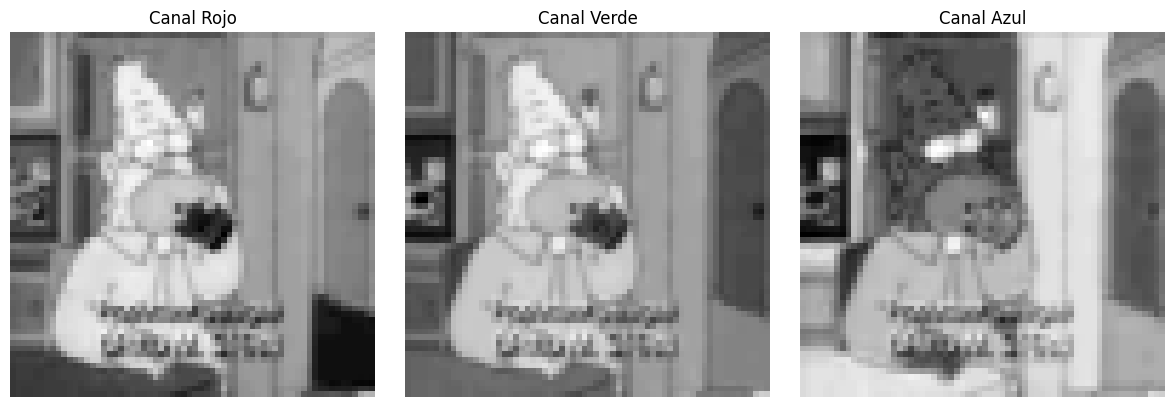

In [13]:
img_tensor, etiqueta = train_dataset[0]

print("Tamaño tensor:", img_tensor.size())
print("Etiqueta:", etiqueta)

print("Visualizacion numerica de ejemplo del canal rojo:\n", img_tensor[0])

# Visuaización de los canales
# Crear una figura con 3 subplots en una fila
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Canal rojo
axs[0].imshow(img_tensor[0], cmap='gray')
axs[0].set_title("Canal Rojo")
axs[0].axis('off')

# Canal verde
axs[1].imshow(img_tensor[1], cmap='gray')
axs[1].set_title("Canal Verde")
axs[1].axis('off')

# Canal azul
axs[2].imshow(img_tensor[2], cmap='gray')
axs[2].set_title("Canal Azul")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Teniendo ya cargados los datasets, hacer uso de ellos tal cual no es muy eficiente ya que habria que ir accediendo a las imagenes una por una. Por ello, existe un ultimo paso en la carga de la informacion que es utilizar DataLoader, donde se generan bloques o batch de imagenes como unidad durante el entrenamiento del modelo. Esto hace que todo el proceso sea mucho más rápido y ordenado.

In [14]:
# 🧳 DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Se barajan los datos en cada época para evitar sobreajuste
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Una vez generados los batches, visualizamos uno de ejemplo.

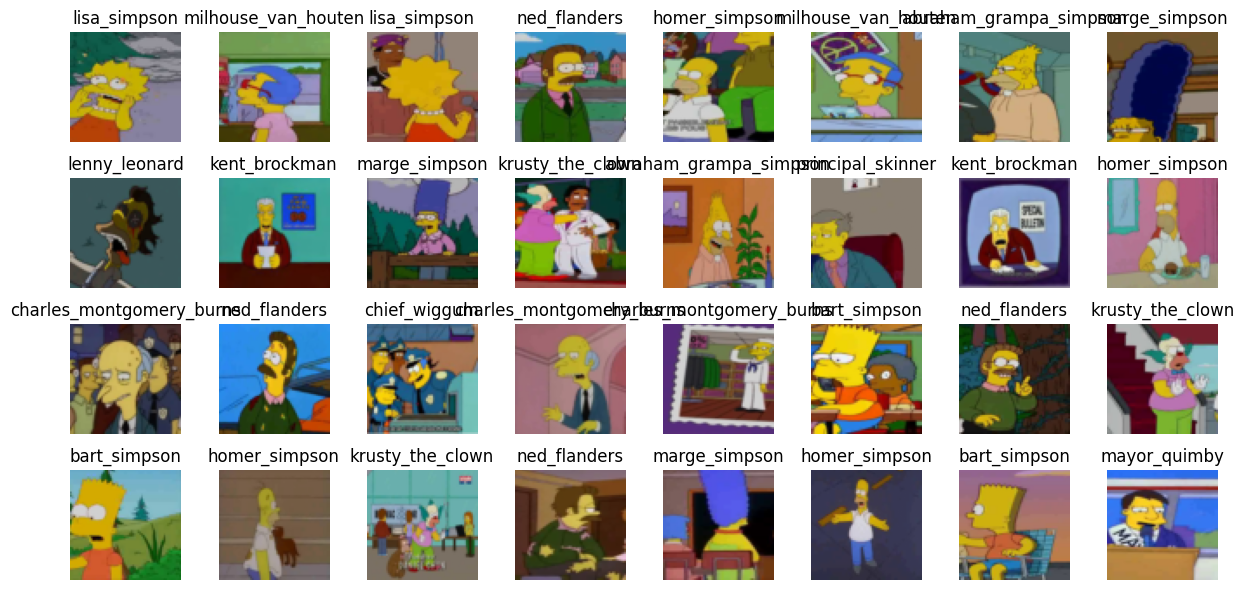

In [15]:
# Visualización de imágenes
def show_batch(loader, dataset):
    images, labels = next(iter(loader))                         # Obtiene un batch de imágenes y etiquetas del DataLoader.
    fig, ax = plt.subplots(4, 8, figsize=(12, 6))               # Crea una figura con una cuadrícula de 4 filas y 8 columnas para mostrar 32 imágenes.
    for i in range(32):                                         # Itera sobre las primeras 32 imágenes del batch.
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5            # Cambia el orden de los ejes del tensor (C, H, W → H, W, C) y desnormaliza los valores.
        ax[i//8, i%8].imshow(img)                               # Muestra la imagen en la posición correspondiente de la cuadrícula.
        ax[i//8, i%8].axis('off')                               # Oculta los ejes de la imagen.
        ax[i//8, i%8].set_title(dataset.classes[labels[i]])     # Establece el título con el nombre de la clase correspondiente a la etiqueta.
    plt.tight_layout()                                          # Ajusta el espaciado entre subgráficos para evitar superposiciones.
    plt.show()                                                  # Muestra la figura con las imágenes.

# Visualiza un batch de entrenamiento
show_batch(train_loader, train_dataset)

## Modelo 1 (CNN simple)

En esta sección se va a desarrollar un modelo CNN simple. Aunque Keras o TensorFlow pueden ser mas amigables a la hora de programar un modelo, este será desarrollado en PyTorch dado que es más complicado (estamos para aprender) y más utilizado en casos reales.

### Entrenamiento inicial

En primer lugar se mira si existe disponible GPU puesto que es mas eficiente para modelos de CNN. En caso contrario, se usara el CPU:

In [16]:
# 📦 Usa GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


Se va a desarrollar una CNN basica, con dos partes:

1. `self.conv_layer` → Está compuesto por **6 capas en total**, organizadas en **2 bloques**:

    - **Conv2D**: capas convolucionales que extraen patrones visuales como bordes, colores o texturas. La primera convierte de 3 canales (RGB) a 32 mapas de características, y la segunda de 32 a 64.
    
    - **ReLU**: funciones de activación no lineales que permiten a la red aprender relaciones complejas, manteniendo los valores positivos y anulando los negativos.
    
    - **MaxPool2D**: capas de reducción espacial (pooling) que disminuyen el tamaño de las imágenes a la mitad en cada bloque, lo que reduce el coste computacional y mantiene las características más relevantes.

    En conjunto, estos bloques procesan una imagen de entrada de tamaño `(3, 64, 64)` y la transforman en un tensor de tamaño `(64, 16, 16)` al final de esta sección.


2. `self.fc_layer` → Está compuesto por **4 capas secuenciales**, encargadas de realizar la clasificación final a partir de las características extraídas por las convoluciones:

   - **Flatten**: aplana el tensor de salida de tamaño `(64, 16, 16)` proveniente del bloque convolucional, convirtiéndolo en un vector de 16.384 elementos para poder conectarlo a las capas lineales.
   
   - **Linear1 (Fully connected)**: la primera capa totalmente conectada reduce los 16.384 valores a 128 neuronas intermedias.
   
   - **ReLU**: función de activación aplicada entre las dos capas lineales, que introduce no linealidad y permite a la red aprender relaciones más complejas.

   - **Linear2 (Fully connected)**: la segunda capa toma esos 128 valores y los transforma en tantas salidas como clases haya en el problema (`num_classes`).

   En conjunto, este bloque toma la información extraída por las convoluciones y la traduce en una predicción final de clase.



In [17]:
#  Modelo CNN simple
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Inicializa la red convolucional simple.

        :param num_classes: Número de clases de salida (10 en este caso).
        """
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # Toma 3 canales de entrada (RGB), aplica 32 filtros de convolución de tamaño 3x3, y padding de 1 para mantener el tamaño de la imagen.
            nn.ReLU(),                                      # Modifica el valor de cada celda: Si x < 0, entonces f(x) = 0. Si x >= 0, entonces f(x) = x.
            nn.MaxPool2d(2),                                # Reduce las dimensiones de la imagen a la mitad (de 64x64 → 32x32) mediante max pooling con kernel 2x2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # Toma 32 canales de entrada (del bloque anterior), aplica 64 filtros de convolución de tamaño 3x3, y padding de 1 para mantener el tamaño de la imagen.
            nn.ReLU(),                                      # Modifica el valor de cada celda: Si x < 0, entonces f(x) = 0. Si x >= 0, entonces f(x) = x.
            nn.MaxPool2d(2),                                # Reduce las dimensiones de la imagen a la mitad (de 32x32 → 16x16) mediante max pooling con kernel 2x2
        )

        # Output: (64, 16, 16) (64 canales de salida, cada uno de tamaño 16x16)

        self.fc_layer = nn.Sequential(

            nn.Flatten(),                                   # Aplana el tensor de salida de la parte convolucional (64, 16, 16) en un vector de tamaño 64*16*16 para poder pasarlo a capas lineales.
            nn.Linear(64 * 16 * 16, 128),                   # Capa totalmente conectada que reduce el vector de entrada (16.384 elementos) a 128 neuronas intermedias.
            nn.ReLU(),                                      # Activación no lineal que permite a la red aprender relaciones complejas.
            nn.Linear(128, num_classes)                     # Capa de salida que mapea las 128 neuronas a tantas salidas como clases tenga el problema (una por clase).

        )

        # Output: Un vector 1D con 10 valores (uno por clase) que representa la probabilidad de que la imagen pertenezca a cada clase.

    def forward(self, x):
        """
        Método de propagación hacia adelante. Define cómo se transforma la entrada a través de la red.

        :param x: Tensor de entrada (batch de imágenes).
        :return: Tensor de salida (predicciones de clase).
        """
        x = self.conv_layer(x)                              # Pasa la entrada a través de las capas convolucionales y de pooling.
        x = self.fc_layer(x)                                # Pasa la salida a través de las capas totalmente conectadas.
        return x                                            # Devuelve la salida final de la red.


A continuación se hace la `instanciación del modelo`

In [18]:
num_classes = len(train_dataset.classes)                # Determina cuántas categorías debe predecir el modelo.
model_1 = SimpleCNN(num_classes).to(device)             # Se crea y se envía al dispositivo (GPU/CPU)

# Esto último esta pensado para que el modelo pueda ser ejecutado en GPU si está disponible, lo que acelerará el entrenamiento y la inferencia.
# Si no hay GPU, el modelo se ejecutará en la CPU, pero se deja programado de esta manera para que sea más eficiente en caso de que el hardware lo permita.

Se determina cuales van a ser la `funcion de perdida` y el `optimizador`

In [19]:
criterion_1 = nn.CrossEntropyLoss()                         # Función de pérdida que combina softmax y cross-entropy en una sola función. Ideal para clasificación multiclase.
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)    # Optimizador Adam, que es una mejora del SGD. Se adapta automáticamente a cada parámetro y tiene un buen rendimiento en la mayoría de los casos.

Por último, se define la `función de entrenamiento`.

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    history = []  # Lista para acumular dicts con métricas por época (resumen para posterior grafica)

    # Bucle principal de entrenamiento por cada época
    for epoch in range(epochs):                         # En cada epoch se recorre todo el dataset de entrenamiento
        model.train()                                   # Activa modo entrenamiento (habilita dropout, batchnorm, etc.)
        running_loss = 0.0                              # Inicializacion variable para acumular la pérdida total (loss) de cada batch a lo largo de toda la época actual
        correct = 0                                     # Inicializacion variable para acumular predicciones correctas en cada batch a lo largo de toda la época actual
        total = 0                                       # Inicializacion variable para contar el número total de ejemplos procesados durante toda la época.

        # Bucle sobre todos los batches del conjunto de entrenamiento (que esta en formato DataLoader))
        for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}"):

            images, labels = images.to(device), labels.to(device)  # Como antes hemos movido el modelo a device (CPU o GPU), se mueven los datos (imágenes y etiquetas) también

            optimizer.zero_grad()                       # Se quiere un gradiente por cada batch. Se reinicia gradiente para no acumular el del batch anterior
            outputs = model(images)                     # Se obtiene la predicción del modelo para el batch actual de imágenes
            loss = criterion(outputs, labels)           # Calcula la pérdida entre predicción y etiqueta real (-log(probabilidad de la clase correcta))
            loss.backward()                             # Backpropagation: se calculan los gradientes de la función de pérdida respecto a los parámetros del modelo (regla de la cadena)
            optimizer.step()                            # Gradient descent: toma los gradientes de loss.backward() y actualiza los pesos del modelo para minimizar la pérdida

# Esta última parte se entiende como:
#   - Forward pass (outputs) → el modelo intenta una predicción.
#   - Cálculo de pérdida → mide qué tan mal lo hizo.
#   - Backward pass (loss.backward()) → calcula cómo corregir los pesos para mejorar (Backpropragation).
#   - Optimizer step → realiza el cambio real en los pesos.

            running_loss += loss.item()                 # Acumula la pérdida por batch para tener un loss final por época
            _, preds = torch.max(outputs, 1)            # Obtiene la clase con mayor probabilidad (predicción)
            correct += (preds == labels).sum().item()   # Acumula el número de cuántas predicciones fueron correctas por batch para tener un total de aciertos por época
            total += labels.size(0)                     # Suma la cantidad total de ejemplos

        # Calcula rendimiento en entrenamiento para la época actual
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        print(f"\n✅ Entrenamiento — Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")


        # --- Validación ---  (similar a entrenamiento)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        # No se calculan gradientes durante validación (ahorra memoria)
        with torch.no_grad():

            # Se repiten los pasos de la validación para cada batch del conjunto de validación (que esta en formato DataLoader))
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calcula rendimiento en validación para la época actual
        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f"🔍 Validación — Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%\n")

        # Guardar métricas en dict
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        })

    history_df = pd.DataFrame(history)

    return model, history_df  # Devuelve el modelo ya entrenado y resumen de metricas a lo largo de las épocas


Se define tambien la función para el entrenamiento del modelo.

In [21]:
def test_model(model, test_loader, class_names):    # Procedimiento basicamente identico al de validación
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    # Crear máscara para la parte superior
    mask = np.triu(np.ones_like(cm, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, mask=mask, annot=False, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap='viridis')
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase verdadera")
    plt.title("Matriz de confusión (mitad inferior)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Accuracy total en test: {acc * 100:.2f}%")

    return classification_report(all_labels, all_preds, target_names=class_names, output_dict=True) # En validación no se imprime por eficiencia, pero en test sí (ya hay un modelo final)

Con todo definido, se entrena el modelo.

In [22]:
# Entrena el modelo
modelo_entrenado_1, resumen_1 = train_model(model_1, train_loader, val_loader, criterion_1, optimizer_1, epochs=10)


Época 1/10: 100%|██████████| 458/458 [00:36<00:00, 12.64it/s]



✅ Entrenamiento — Loss: 2.0801 | Accuracy: 44.44%
🔍 Validación — Loss: 1.6143 | Accuracy: 56.56%



Época 2/10: 100%|██████████| 458/458 [00:34<00:00, 13.39it/s]



✅ Entrenamiento — Loss: 1.2199 | Accuracy: 66.67%
🔍 Validación — Loss: 1.2830 | Accuracy: 65.70%



Época 3/10: 100%|██████████| 458/458 [00:34<00:00, 13.36it/s]



✅ Entrenamiento — Loss: 0.7571 | Accuracy: 78.78%
🔍 Validación — Loss: 1.1483 | Accuracy: 70.29%



Época 4/10: 100%|██████████| 458/458 [00:34<00:00, 13.34it/s]



✅ Entrenamiento — Loss: 0.4250 | Accuracy: 87.70%
🔍 Validación — Loss: 1.2348 | Accuracy: 71.78%



Época 5/10: 100%|██████████| 458/458 [00:34<00:00, 13.34it/s]



✅ Entrenamiento — Loss: 0.2288 | Accuracy: 93.45%
🔍 Validación — Loss: 1.3257 | Accuracy: 72.83%



Época 6/10: 100%|██████████| 458/458 [00:34<00:00, 13.43it/s]



✅ Entrenamiento — Loss: 0.0987 | Accuracy: 97.36%
🔍 Validación — Loss: 1.5407 | Accuracy: 73.34%



Época 7/10: 100%|██████████| 458/458 [00:34<00:00, 13.37it/s]



✅ Entrenamiento — Loss: 0.0691 | Accuracy: 98.12%
🔍 Validación — Loss: 1.7326 | Accuracy: 71.05%



Época 8/10: 100%|██████████| 458/458 [00:34<00:00, 13.38it/s]



✅ Entrenamiento — Loss: 0.0654 | Accuracy: 97.94%
🔍 Validación — Loss: 1.9494 | Accuracy: 72.07%



Época 9/10: 100%|██████████| 458/458 [00:34<00:00, 13.38it/s]



✅ Entrenamiento — Loss: 0.0646 | Accuracy: 98.09%
🔍 Validación — Loss: 1.9050 | Accuracy: 72.23%



Época 10/10: 100%|██████████| 458/458 [00:34<00:00, 13.38it/s]



✅ Entrenamiento — Loss: 0.0753 | Accuracy: 97.51%
🔍 Validación — Loss: 2.0412 | Accuracy: 70.32%



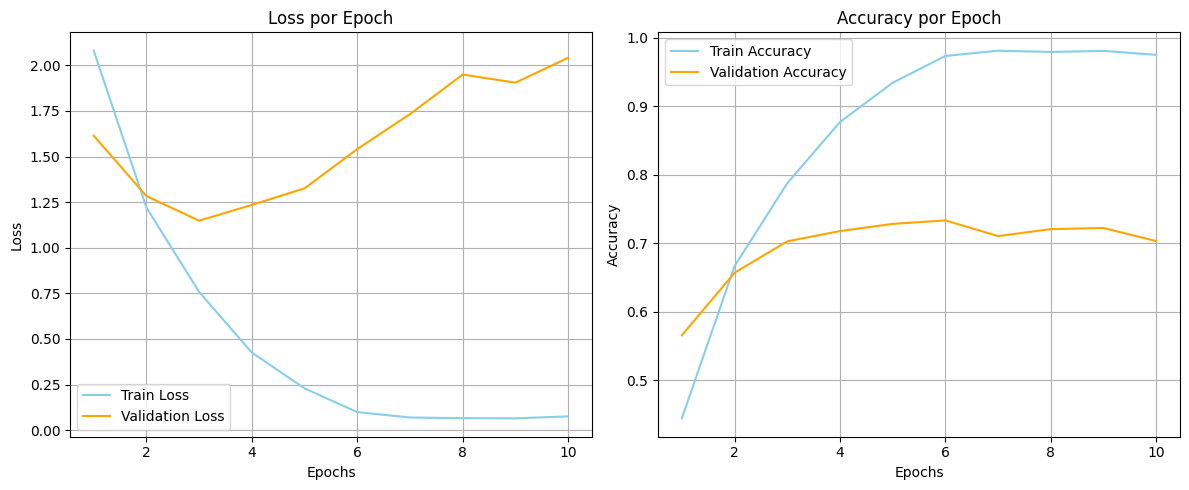

In [23]:
resumen = resumen_1

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

Por último, se evalua el rendimiento del modelo en la muestra test.

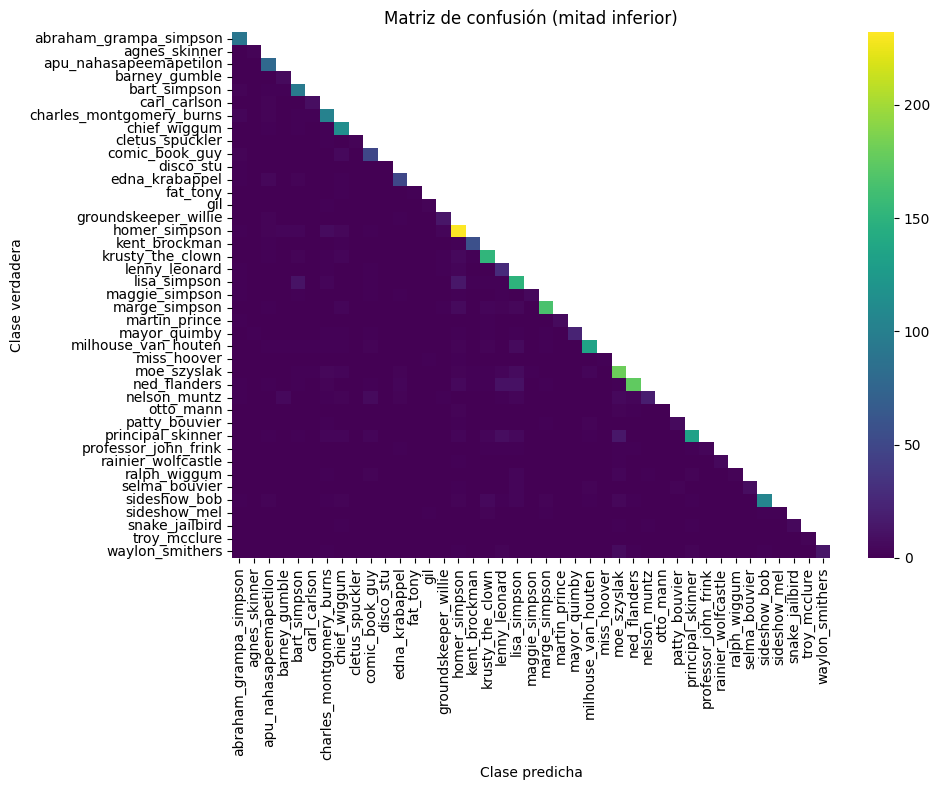

✅ Accuracy total en test: 70.40%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
troy_mcclure               1.000000  1.000000  1.000000      2.0
marge_simpson              0.873016  0.850515  0.861619    194.0
krusty_the_clown           0.808511  0.839779  0.823848    181.0
ned_flanders               0.841346  0.799087  0.819672    219.0
milhouse_van_houten        0.780347  0.833333  0.805970    162.0
kent_brockman              0.838235  0.760000  0.797203     75.0
apu_nahasapeemapetilon     0.764706  0.829787  0.795918     94.0
sideshow_bob               0.751773  0.803030  0.776557    132.0
edna_krabappel             0.790323  0.710145  0.748092     69.0
principal_skinner          0.755682  0.738889  0.747191    180.0
abraham_grampa_simpson     0.842593  0.664234  0.742857    137.0
chief_wiggum               0.708075  0.770270  0.737864    148.0
homer_simpson              0.698795  0.688427  0.693572    337.0
ma

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Evalúa en test
metricas_test_1 = test_model(modelo_entrenado_1, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

Como puede observarse, las clases con peores resultados son aquellas con muy poca materialidad. De hecho, el propio código nos arroja un warning advirtiendo que la precision se esta seteando a 0 debido a el modelo no ha predicho ni una sola muestra de alguna clase. Es decir, el modelo nunca elige algunas clases como predicción.

A continuación, se tratará de ajustar esta debilidad debida al desbalanceo de clases mediante el uso de Data Augmentation u otras técnicas.

In [25]:
del modelo_entrenado_1
del criterion_1
del optimizer_1

### Pruebas Desbalanceo

En esta sección se exploran distintos ajustes o metodologias para solventar el problema de desbalanceo que tiene el dataset, donde existen varias clases con muy pocas imagenes como para que el modelo pueda aprender debidamente.

Aunque los resultados para la elección de la mejor opción podrían variar en caso de haber utilizado más epochs, el análisis se ha hecho solamente utilizando 10 por cuestión de tiempo, memoria y eficiencia.

Una vez elegida cuál es la mejor opción a incluir en el modelo para tratar el desbalanceo, el modelo final será entrenado con un mayor número de epochs para permitir el tiempo suficiente para que el modelo aprenda debidamente.

#### Data Augmentation dinámico

Para este modelo, ademas de las transformaciones del modelo anterior se incluyen transformaciones adicionales de Data augmentation:

- RandomHorizontalFlip: Invierte horizontalmente imágenes aleatoriamente. Solo durante entrenamiento.
- RandomRotation: Rota aleatoriamente las imagenes hasta un maximo de grados indicados. Solo durante entrenamiento
- ColorJitter: Varia los colores de la foto, ajustando contrastes y tonalidades. Solo durante entrenamiento.

Estos ajustes solamente aplicarán en la muestra de entrenamiento, puesto que el data augmentation no se debe aplicar a las muestras de test y val.

Para su aplicación, existen dos opciones, en este modelo se evalua la primera (dinámico) y posteriormente se analiza la segunda (estático):
- Aplicación dinámico: Cada vez que el modelo coge una imagen para su entrenamiento se aplica la transformación, pero se mantiene el mismo número de imagenes -> **solo aplica a la muestra train**

In [26]:
# 🔄 Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),                                # Redimensiona todas las imágenes a 64x64 píxeles.
    transforms.RandomHorizontalFlip(),                          # Invierte horizontalmente imágenes aleatoriamente (data augmentation).
    transforms.RandomRotation(15),                              # Rota las imágenes aleatoriamente hasta ±15 grados (data augmentation).
    transforms.ColorJitter(brightness=0.3, contrast=0.3),       # Cambia las tonalidades de la imagen
    transforms.ToTensor(),                                      # Convierte la imagen en un tensor PyTorch y normaliza a [0, 1].
    transforms.Normalize([0.5], [0.5])                          # Normaliza los valores de cada canal a un rango de [-1, 1].
])

# 📂 Datasets
train_dataset_aug1 = datasets.ImageFolder(train_dir, transform=transform_train)

# 🧳 DataLoaders
train_loader_aug1 = DataLoader(train_dataset_aug1, batch_size=32, shuffle=True) # Se barajan los datos en cada época para evitar sobreajuste

El modelo es exactamente igual al anterior, solo que el dataset de entrada con el que se entrena ha sido ajustado.

In [27]:
# Entrena el modelo
model_1_aug1 = SimpleCNN(num_classes).to(device)
criterion_1_aug1 = nn.CrossEntropyLoss()
optimizer_1_aug1 = optim.Adam(model_1_aug1.parameters(), lr=0.001)

modelo_entrenado_1_aug1, resumen_1_aug1 = train_model(model_1_aug1, train_loader_aug1, val_loader, criterion_1_aug1, optimizer_1_aug1, epochs=10)

Época 1/10: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 2.2509 | Accuracy: 39.46%
🔍 Validación — Loss: 1.7507 | Accuracy: 53.31%



Época 2/10: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 1.5858 | Accuracy: 56.83%
🔍 Validación — Loss: 1.4287 | Accuracy: 60.19%



Época 3/10: 100%|██████████| 458/458 [00:41<00:00, 11.11it/s]



✅ Entrenamiento — Loss: 1.2696 | Accuracy: 64.76%
🔍 Validación — Loss: 1.3396 | Accuracy: 63.44%



Época 4/10: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 1.0951 | Accuracy: 69.35%
🔍 Validación — Loss: 1.1321 | Accuracy: 69.59%



Época 5/10: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.9404 | Accuracy: 73.77%
🔍 Validación — Loss: 1.0384 | Accuracy: 72.80%



Época 6/10: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.8160 | Accuracy: 76.78%
🔍 Validación — Loss: 0.9905 | Accuracy: 74.52%



Época 7/10: 100%|██████████| 458/458 [00:41<00:00, 11.13it/s]



✅ Entrenamiento — Loss: 0.7453 | Accuracy: 79.06%
🔍 Validación — Loss: 0.9561 | Accuracy: 75.00%



Época 8/10: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.6570 | Accuracy: 81.56%
🔍 Validación — Loss: 0.9471 | Accuracy: 76.02%



Época 9/10: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.5804 | Accuracy: 83.36%
🔍 Validación — Loss: 0.9878 | Accuracy: 75.70%



Época 10/10: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.5335 | Accuracy: 84.90%
🔍 Validación — Loss: 0.9521 | Accuracy: 76.59%



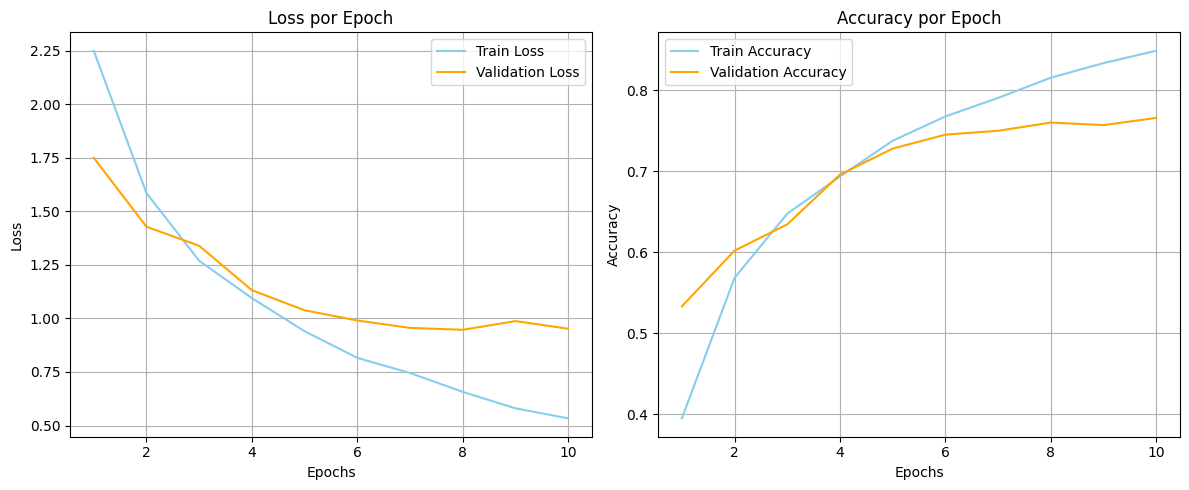

In [28]:
resumen = resumen_1_aug1

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

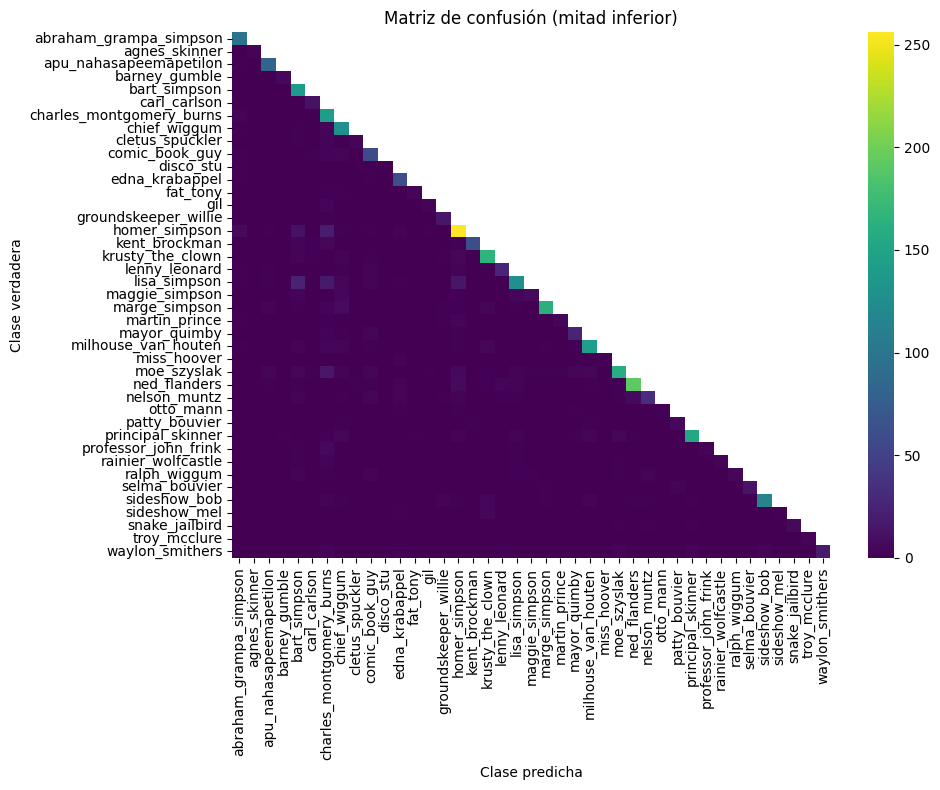

✅ Accuracy total en test: 76.61%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
troy_mcclure               1.000000  1.000000  1.000000      2.0
marge_simpson              0.941860  0.835052  0.885246    194.0
apu_nahasapeemapetilon     0.881720  0.872340  0.877005     94.0
sideshow_bob               0.877863  0.871212  0.874525    132.0
krusty_the_clown           0.816832  0.911602  0.861619    181.0
principal_skinner          0.869318  0.850000  0.859551    180.0
kent_brockman              0.936508  0.786667  0.855072     75.0
ned_flanders               0.813559  0.876712  0.843956    219.0
edna_krabappel             0.779221  0.869565  0.821918     69.0
milhouse_van_houten        0.755319  0.876543  0.811429    162.0
selma_bouvier              0.764706  0.812500  0.787879     16.0
moe_szyslak                0.854839  0.729358  0.787129    218.0
chief_wiggum               0.728324  0.851351  0.785047    148.0
ab

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Evalúa en test
metricas_test_1_aug1 = test_model(modelo_entrenado_1_aug1, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug1).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

Se obtienen mejores resultados que con el modelo original.

A continuación se evalua otra metodología para ver si se obtienen resultados todavía mejores o peores.

In [30]:
del modelo_entrenado_1_aug1
del criterion_1_aug1
del optimizer_1_aug1

#### Data Augmentation estático

Para este modelo, se aplica otro enfoque de Data Augmentation, generando imagenes nuevas en vez de modificar las existentes.

- Aplicación estático: Se generan copias modificadas de las imagenes originales, aumentando la materialidad de las clases. Concretamente, esta opción resulta más adecuada en casos como este, donde hay clases desbalanceadas -> **solo aplica a la muestra train**


In [31]:
# Rutas
train_dir_aug = train_dir + "_aug"
min_images_per_class = 200

# Transformaciones estático
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3)
])

# Crear nueva carpeta con copia completa del dataset original
if os.path.exists(train_dir_aug):
    shutil.rmtree(train_dir_aug)
shutil.copytree(train_dir, train_dir_aug)

# Recorre cada clase en la carpeta nueva (ya copiada)
for clase in os.listdir(train_dir_aug):
    clase_path = os.path.join(train_dir_aug, clase)
    imagenes = [f for f in os.listdir(clase_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    if len(imagenes) < min_images_per_class:    # Se identifican las clases con una materialidad inferior a la considerada (min_images_per_class)
        img_paths = [os.path.join(clase_path, f) for f in imagenes]
        num_to_generate = min_images_per_class - len(imagenes)

        for i in tqdm(range(num_to_generate), desc=f"Generando imagenes en {clase} hasta llegar a {min_images_per_class}"):   # Se generan copias aplicando las transformaciones, hasta llegar a min_images_per_class
            img_path = random.choice(img_paths)
            img = Image.open(img_path).convert("RGB")
            img_aug = augmentation_transforms(img)
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            save_path = os.path.join(clase_path, f"{base_name}_aug{i}.jpg")
            img_aug.save(save_path)

print("\n✅ Dataset aumentado creado en:", train_dir_aug)


# 📂 Datasets
train_dataset_aug2 = datasets.ImageFolder(train_dir_aug, transform=transform)

# 🧳 DataLoaders
train_loader_aug2 = DataLoader(train_dataset_aug2, batch_size=32, shuffle=True) # Se barajan los datos en cada época para evitar sobreajuste


Generando imagenes en groundskeeper_willie hasta llegar a 200: 100%|██████████| 116/116 [00:00<00:00, 133.54it/s]
Generando imagenes en rainier_wolfcastle hasta llegar a 200: 100%|██████████| 169/169 [00:01<00:00, 140.00it/s]
Generando imagenes en fat_tony hasta llegar a 200: 100%|██████████| 182/182 [00:01<00:00, 138.31it/s]
Generando imagenes en professor_john_frink hasta llegar a 200: 100%|██████████| 155/155 [00:01<00:00, 123.11it/s]
Generando imagenes en selma_bouvier hasta llegar a 200: 100%|██████████| 128/128 [00:00<00:00, 178.51it/s]
Generando imagenes en martin_prince hasta llegar a 200: 100%|██████████| 151/151 [00:01<00:00, 135.91it/s]
Generando imagenes en gil hasta llegar a 200: 100%|██████████| 182/182 [00:01<00:00, 165.75it/s]
Generando imagenes en ralph_wiggum hasta llegar a 200: 100%|██████████| 138/138 [00:01<00:00, 133.94it/s]
Generando imagenes en miss_hoover hasta llegar a 200: 100%|██████████| 189/189 [00:01<00:00, 148.09it/s]
Generando imagenes en mayor_quimby h


✅ Dataset aumentado creado en: ./simpsons_split_dataset/train_aug


El modelo es exactamente igual al anterior, solo que ha cambiado el enfoque de Data Augmentation.

In [32]:
# Entrena el modelo
model_1_aug2 = SimpleCNN(num_classes).to(device)
criterion_1_aug2 = nn.CrossEntropyLoss()
optimizer_1_aug2 = optim.Adam(model_1_aug2.parameters(), lr=0.001)

modelo_entrenado_1_aug2, resumen_1_aug2 = train_model(model_1_aug2, train_loader_aug2, val_loader, criterion_1_aug2, optimizer_1_aug2, epochs=10)

Época 1/10: 100%|██████████| 560/560 [00:42<00:00, 13.16it/s]



✅ Entrenamiento — Loss: 2.1186 | Accuracy: 43.84%
🔍 Validación — Loss: 1.6038 | Accuracy: 56.02%



Época 2/10: 100%|██████████| 560/560 [00:42<00:00, 13.25it/s]



✅ Entrenamiento — Loss: 1.0350 | Accuracy: 71.35%
🔍 Validación — Loss: 1.2441 | Accuracy: 68.12%



Época 3/10: 100%|██████████| 560/560 [00:42<00:00, 13.21it/s]



✅ Entrenamiento — Loss: 0.5905 | Accuracy: 83.39%
🔍 Validación — Loss: 1.1808 | Accuracy: 71.15%



Época 4/10: 100%|██████████| 560/560 [00:42<00:00, 13.29it/s]



✅ Entrenamiento — Loss: 0.3095 | Accuracy: 90.97%
🔍 Validación — Loss: 1.2501 | Accuracy: 72.07%



Época 5/10: 100%|██████████| 560/560 [00:42<00:00, 13.31it/s]



✅ Entrenamiento — Loss: 0.1512 | Accuracy: 95.51%
🔍 Validación — Loss: 1.3402 | Accuracy: 73.15%



Época 6/10: 100%|██████████| 560/560 [00:42<00:00, 13.28it/s]



✅ Entrenamiento — Loss: 0.0859 | Accuracy: 97.64%
🔍 Validación — Loss: 1.7392 | Accuracy: 71.05%



Época 7/10: 100%|██████████| 560/560 [00:42<00:00, 13.17it/s]



✅ Entrenamiento — Loss: 0.0737 | Accuracy: 97.75%
🔍 Validación — Loss: 1.7858 | Accuracy: 70.03%



Época 8/10: 100%|██████████| 560/560 [00:42<00:00, 13.21it/s]



✅ Entrenamiento — Loss: 0.0807 | Accuracy: 97.56%
🔍 Validación — Loss: 1.7853 | Accuracy: 71.27%



Época 9/10: 100%|██████████| 560/560 [00:42<00:00, 13.17it/s]



✅ Entrenamiento — Loss: 0.0678 | Accuracy: 98.03%
🔍 Validación — Loss: 1.9577 | Accuracy: 72.07%



Época 10/10: 100%|██████████| 560/560 [00:42<00:00, 13.23it/s]



✅ Entrenamiento — Loss: 0.0472 | Accuracy: 98.51%
🔍 Validación — Loss: 1.9797 | Accuracy: 72.96%



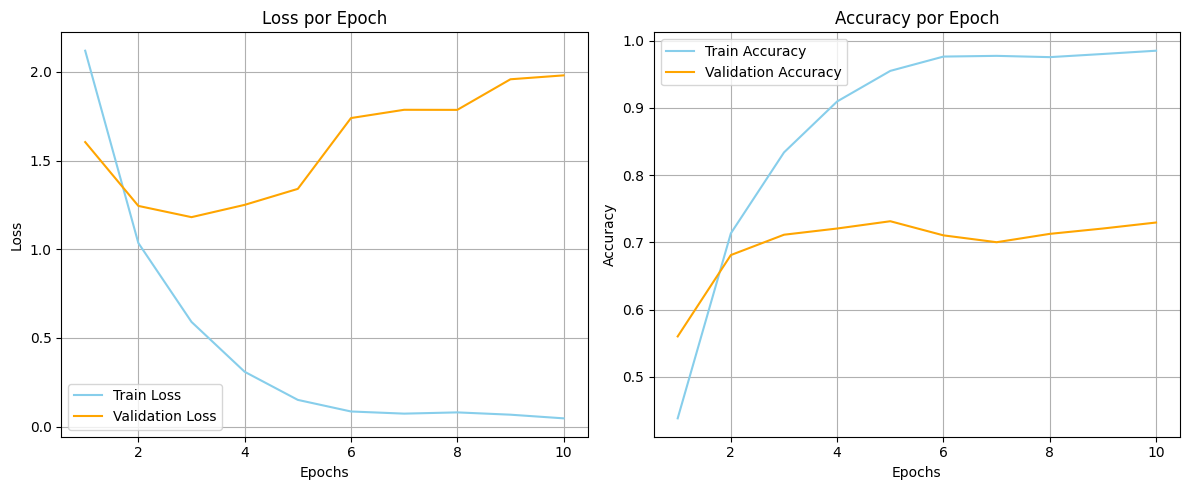

In [33]:
resumen = resumen_1_aug2

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

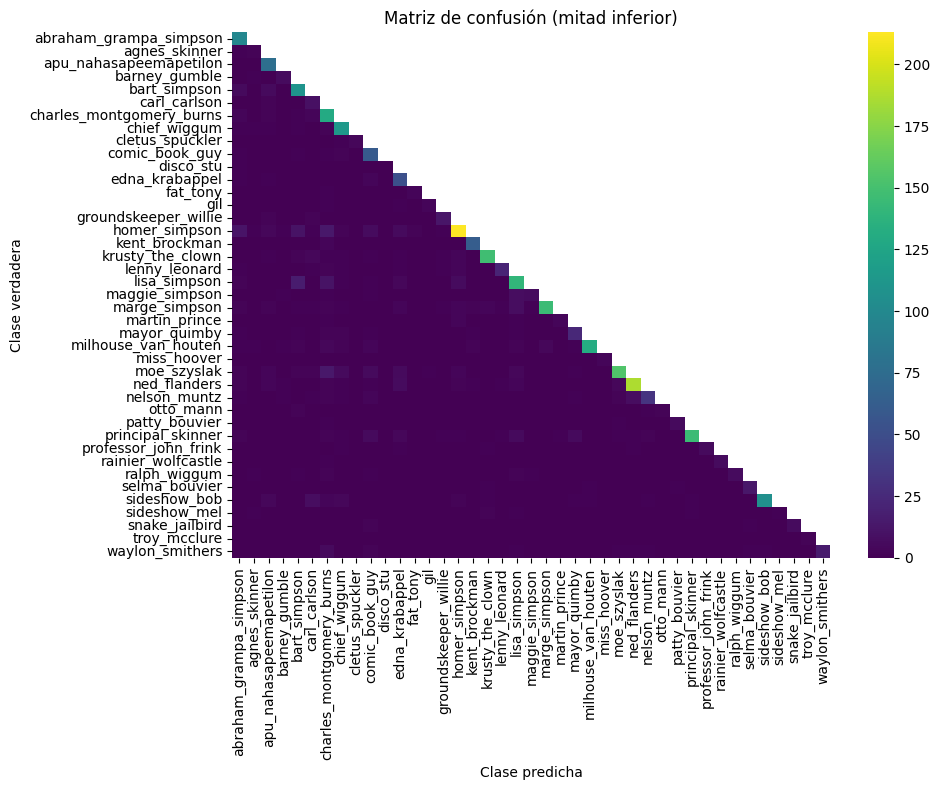

✅ Accuracy total en test: 71.57%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
troy_mcclure               1.000000  1.000000  1.000000      2.0
miss_hoover                1.000000  1.000000  1.000000      3.0
rainier_wolfcastle         0.857143  0.857143  0.857143      7.0
krusty_the_clown           0.886228  0.817680  0.850575    181.0
milhouse_van_houten        0.879195  0.808642  0.842444    162.0
sideshow_bob               0.876033  0.803030  0.837945    132.0
marge_simpson              0.935484  0.747423  0.830946    194.0
kent_brockman              0.775000  0.826667  0.800000     75.0
ned_flanders               0.697761  0.853881  0.767967    219.0
chief_wiggum               0.765101  0.770270  0.767677    148.0
principal_skinner          0.732323  0.805556  0.767196    180.0
apu_nahasapeemapetilon     0.706422  0.819149  0.758621     94.0
snake_jailbird             0.857143  0.666667  0.750000      9.0
ab

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Evalúa en test
metricas_test_1_aug2 = test_model(modelo_entrenado_1_aug2, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug2).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

Se obtienen resultados peores y con un mayor overfitting, tal y como se puede observar en las metricas de accuracy entre la muestra train (muy alto) y la de validacion (mucho mas bajo).

In [35]:
del modelo_entrenado_1_aug2
del criterion_1_aug2
del optimizer_1_aug2

#### Data Augmentation dinámico + CrossEntropy Balanced

Se concluye que el enfoque dinámico tiene mejores resultados. Como último análisis, se analiza si esta opción puede verse todavía más mejorada si se ajusta el criterio de pérdida utilizado (CrossEntropy) pero ajustado al desbalanceo, dandoles un mayor peso a las clases minoritarias en el entrenamiento del modelo (class_weight='balanced').

In [36]:
from sklearn.utils.class_weight import compute_class_weight

# Paso 1: Obtener los targets (etiquetas) del dataset
labels = train_dataset.targets  # Asegúrate de que esto devuelva una lista o array de ints

# Paso 2: Calcular pesos por clase
import numpy as np
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=np.array(labels))

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

El modelo es exactamente igual al Data Augmentation dinámico, solo que se ajusta el criterio de perdida con `class_weights`.

In [37]:
# Entrena el modelo
model_1_aug1_bal = SimpleCNN(num_classes).to(device)
criterion_1_aug1_bal = nn.CrossEntropyLoss(weight=class_weights)
optimizer_1_aug1_bal = optim.Adam(model_1_aug1_bal.parameters(), lr=0.001)

modelo_entrenado_1_aug1_bal, resumen_1_aug1_bal = train_model(model_1_aug1_bal, train_loader, val_loader, criterion_1_aug1_bal, optimizer_1_aug1_bal, epochs=10)

Época 1/10: 100%|██████████| 458/458 [00:34<00:00, 13.21it/s]



✅ Entrenamiento — Loss: 3.2976 | Accuracy: 20.40%
🔍 Validación — Loss: 2.6573 | Accuracy: 32.32%



Época 2/10: 100%|██████████| 458/458 [00:34<00:00, 13.22it/s]



✅ Entrenamiento — Loss: 2.2244 | Accuracy: 40.05%
🔍 Validación — Loss: 2.0610 | Accuracy: 45.54%



Época 3/10: 100%|██████████| 458/458 [00:34<00:00, 13.29it/s]



✅ Entrenamiento — Loss: 1.4693 | Accuracy: 52.29%
🔍 Validación — Loss: 1.9535 | Accuracy: 48.73%



Época 4/10: 100%|██████████| 458/458 [00:34<00:00, 13.17it/s]



✅ Entrenamiento — Loss: 0.9149 | Accuracy: 62.57%
🔍 Validación — Loss: 1.8029 | Accuracy: 54.94%



Época 5/10: 100%|██████████| 458/458 [00:34<00:00, 13.09it/s]



✅ Entrenamiento — Loss: 0.6163 | Accuracy: 71.05%
🔍 Validación — Loss: 1.7466 | Accuracy: 60.57%



Época 6/10: 100%|██████████| 458/458 [00:34<00:00, 13.17it/s]



✅ Entrenamiento — Loss: 0.3793 | Accuracy: 79.17%
🔍 Validación — Loss: 1.7672 | Accuracy: 63.47%



Época 7/10: 100%|██████████| 458/458 [00:34<00:00, 13.21it/s]



✅ Entrenamiento — Loss: 0.2569 | Accuracy: 85.37%
🔍 Validación — Loss: 1.8738 | Accuracy: 65.32%



Época 8/10: 100%|██████████| 458/458 [00:34<00:00, 13.27it/s]



✅ Entrenamiento — Loss: 0.1627 | Accuracy: 90.02%
🔍 Validación — Loss: 2.0470 | Accuracy: 66.02%



Época 9/10: 100%|██████████| 458/458 [00:34<00:00, 13.17it/s]



✅ Entrenamiento — Loss: 0.1216 | Accuracy: 92.50%
🔍 Validación — Loss: 2.2007 | Accuracy: 65.86%



Época 10/10: 100%|██████████| 458/458 [00:34<00:00, 13.22it/s]



✅ Entrenamiento — Loss: 0.1063 | Accuracy: 93.53%
🔍 Validación — Loss: 2.3827 | Accuracy: 67.20%



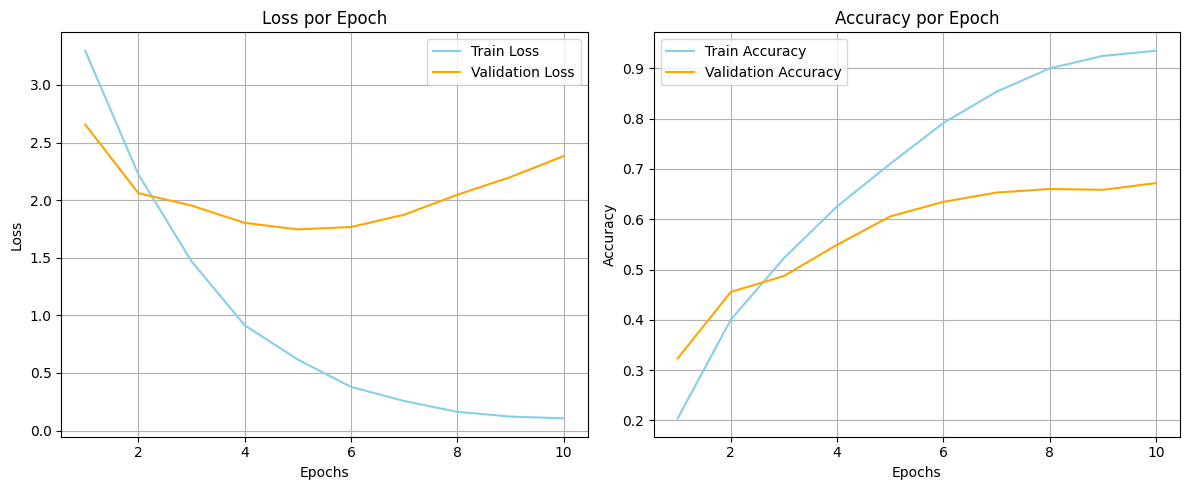

In [38]:
resumen = resumen_1_aug1_bal

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

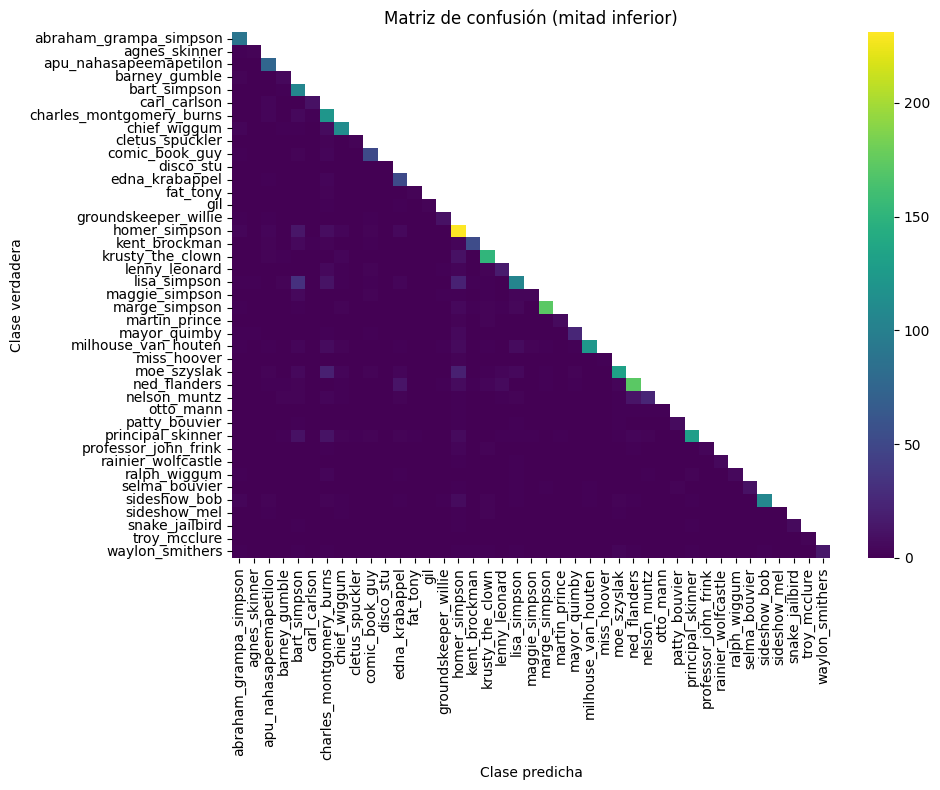

✅ Accuracy total en test: 67.87%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
troy_mcclure               1.000000  1.000000  1.000000      2.0
marge_simpson              0.873096  0.886598  0.879795    194.0
sideshow_bob               0.856000  0.810606  0.832685    132.0
krusty_the_clown           0.751244  0.834254  0.790576    181.0
apu_nahasapeemapetilon     0.765306  0.797872  0.781250     94.0
milhouse_van_houten        0.792208  0.753086  0.772152    162.0
rainier_wolfcastle         0.833333  0.714286  0.769231      7.0
chief_wiggum               0.770833  0.750000  0.760274    148.0
kent_brockman              0.815385  0.706667  0.757143     75.0
ned_flanders               0.704918  0.785388  0.742981    219.0
comic_book_guy             0.753623  0.732394  0.742857     71.0
abraham_grampa_simpson     0.818182  0.656934  0.728745    137.0
selma_bouvier              0.833333  0.625000  0.714286     16.0
sn

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# Evalúa en test
metricas_test_1_aug1_bal = test_model(modelo_entrenado_1_aug1_bal, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug1_bal).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

In [40]:
del modelo_entrenado_1_aug1_bal
del criterion_1_aug1_bal
del optimizer_1_aug1_bal

Como **conclusión final** se tiene que la opción que ajusta mejor el desbalanceo de las clases es utilizar Data Augmentation dinámico, pero sin ajustes adicionales sobre el criterio de pérdida.

### Entrenamiento final

Habiendo elegido el mejor ajuste, se vuelve a ejecutar el modelo pero para un mayor número de epocas (100), para ver hasta donde puede llegar el acierto del modelo (el objetivo es llegar a 90% de accuracy).

In [41]:
# Entrena el modelo
model_1_aug1 = SimpleCNN(num_classes).to(device)
criterion_1_aug1 = nn.CrossEntropyLoss()
optimizer_1_aug1 = optim.Adam(model_1_aug1.parameters(), lr=0.001)

modelo_entrenado_1_aug1, resumen_1_aug1 = train_model(model_1_aug1, train_loader_aug1, val_loader, criterion_1_aug1, optimizer_1_aug1, epochs=50)

Época 1/50: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 2.2211 | Accuracy: 39.94%
🔍 Validación — Loss: 1.7522 | Accuracy: 51.72%



Época 2/50: 100%|██████████| 458/458 [00:40<00:00, 11.20it/s]



✅ Entrenamiento — Loss: 1.5033 | Accuracy: 58.62%
🔍 Validación — Loss: 1.3785 | Accuracy: 63.89%



Época 3/50: 100%|██████████| 458/458 [00:40<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 1.1972 | Accuracy: 66.82%
🔍 Validación — Loss: 1.2159 | Accuracy: 67.45%



Época 4/50: 100%|██████████| 458/458 [00:40<00:00, 11.19it/s]



✅ Entrenamiento — Loss: 1.0033 | Accuracy: 72.35%
🔍 Validación — Loss: 1.1007 | Accuracy: 69.49%



Época 5/50: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.8534 | Accuracy: 76.21%
🔍 Validación — Loss: 0.9975 | Accuracy: 73.50%



Época 6/50: 100%|██████████| 458/458 [00:41<00:00, 11.08it/s]



✅ Entrenamiento — Loss: 0.7373 | Accuracy: 79.26%
🔍 Validación — Loss: 0.9689 | Accuracy: 74.14%



Época 7/50: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.6317 | Accuracy: 82.33%
🔍 Validación — Loss: 0.9362 | Accuracy: 76.05%



Época 8/50: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.5667 | Accuracy: 84.16%
🔍 Validación — Loss: 0.9151 | Accuracy: 76.85%



Época 9/50: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.5071 | Accuracy: 85.65%
🔍 Validación — Loss: 0.9165 | Accuracy: 76.56%



Época 10/50: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.4534 | Accuracy: 87.14%
🔍 Validación — Loss: 0.9268 | Accuracy: 78.25%



Época 11/50: 100%|██████████| 458/458 [00:41<00:00, 10.96it/s]



✅ Entrenamiento — Loss: 0.4060 | Accuracy: 88.13%
🔍 Validación — Loss: 0.9528 | Accuracy: 78.38%



Época 12/50: 100%|██████████| 458/458 [00:41<00:00, 10.97it/s]



✅ Entrenamiento — Loss: 0.3722 | Accuracy: 89.28%
🔍 Validación — Loss: 0.9666 | Accuracy: 77.61%



Época 13/50: 100%|██████████| 458/458 [00:42<00:00, 10.87it/s]



✅ Entrenamiento — Loss: 0.3330 | Accuracy: 90.08%
🔍 Validación — Loss: 0.9262 | Accuracy: 79.55%



Época 14/50: 100%|██████████| 458/458 [00:41<00:00, 10.97it/s]



✅ Entrenamiento — Loss: 0.2936 | Accuracy: 91.38%
🔍 Validación — Loss: 1.0374 | Accuracy: 78.41%



Época 15/50: 100%|██████████| 458/458 [00:41<00:00, 10.98it/s]



✅ Entrenamiento — Loss: 0.2786 | Accuracy: 91.91%
🔍 Validación — Loss: 1.0018 | Accuracy: 79.11%



Época 16/50: 100%|██████████| 458/458 [00:41<00:00, 11.09it/s]



✅ Entrenamiento — Loss: 0.2452 | Accuracy: 92.70%
🔍 Validación — Loss: 1.0241 | Accuracy: 79.36%



Época 17/50: 100%|██████████| 458/458 [00:42<00:00, 10.89it/s]



✅ Entrenamiento — Loss: 0.2313 | Accuracy: 93.30%
🔍 Validación — Loss: 1.0575 | Accuracy: 79.04%



Época 18/50: 100%|██████████| 458/458 [00:41<00:00, 10.95it/s]



✅ Entrenamiento — Loss: 0.2191 | Accuracy: 93.49%
🔍 Validación — Loss: 1.1384 | Accuracy: 78.92%



Época 19/50: 100%|██████████| 458/458 [00:41<00:00, 11.00it/s]



✅ Entrenamiento — Loss: 0.2079 | Accuracy: 93.73%
🔍 Validación — Loss: 1.1571 | Accuracy: 79.46%



Época 20/50: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.1887 | Accuracy: 94.46%
🔍 Validación — Loss: 1.0972 | Accuracy: 79.52%



Época 21/50: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.1754 | Accuracy: 94.68%
🔍 Validación — Loss: 1.1659 | Accuracy: 79.68%



Época 22/50: 100%|██████████| 458/458 [00:41<00:00, 11.11it/s]



✅ Entrenamiento — Loss: 0.1773 | Accuracy: 94.57%
🔍 Validación — Loss: 1.0871 | Accuracy: 80.45%



Época 23/50: 100%|██████████| 458/458 [00:41<00:00, 11.00it/s]



✅ Entrenamiento — Loss: 0.1689 | Accuracy: 95.00%
🔍 Validación — Loss: 1.1863 | Accuracy: 80.35%



Época 24/50: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.1563 | Accuracy: 95.52%
🔍 Validación — Loss: 1.2242 | Accuracy: 80.73%



Época 25/50: 100%|██████████| 458/458 [00:41<00:00, 11.00it/s]



✅ Entrenamiento — Loss: 0.1455 | Accuracy: 95.64%
🔍 Validación — Loss: 1.1470 | Accuracy: 80.76%



Época 26/50: 100%|██████████| 458/458 [00:41<00:00, 10.95it/s]



✅ Entrenamiento — Loss: 0.1413 | Accuracy: 95.76%
🔍 Validación — Loss: 1.2636 | Accuracy: 80.13%



Época 27/50: 100%|██████████| 458/458 [00:42<00:00, 10.88it/s]



✅ Entrenamiento — Loss: 0.1241 | Accuracy: 96.09%
🔍 Validación — Loss: 1.3153 | Accuracy: 79.78%



Época 28/50: 100%|██████████| 458/458 [00:42<00:00, 10.75it/s]



✅ Entrenamiento — Loss: 0.1247 | Accuracy: 96.34%
🔍 Validación — Loss: 1.2956 | Accuracy: 80.19%



Época 29/50: 100%|██████████| 458/458 [00:42<00:00, 10.81it/s]



✅ Entrenamiento — Loss: 0.1311 | Accuracy: 96.14%
🔍 Validación — Loss: 1.1771 | Accuracy: 81.40%



Época 30/50: 100%|██████████| 458/458 [00:42<00:00, 10.83it/s]



✅ Entrenamiento — Loss: 0.1273 | Accuracy: 96.17%
🔍 Validación — Loss: 1.3413 | Accuracy: 80.48%



Época 31/50: 100%|██████████| 458/458 [00:42<00:00, 10.87it/s]



✅ Entrenamiento — Loss: 0.1259 | Accuracy: 96.11%
🔍 Validación — Loss: 1.3601 | Accuracy: 79.55%



Época 32/50: 100%|██████████| 458/458 [00:42<00:00, 10.88it/s]



✅ Entrenamiento — Loss: 0.1140 | Accuracy: 96.55%
🔍 Validación — Loss: 1.3937 | Accuracy: 79.62%



Época 33/50: 100%|██████████| 458/458 [00:41<00:00, 10.91it/s]



✅ Entrenamiento — Loss: 0.1058 | Accuracy: 96.71%
🔍 Validación — Loss: 1.4546 | Accuracy: 79.55%



Época 34/50: 100%|██████████| 458/458 [00:42<00:00, 10.90it/s]



✅ Entrenamiento — Loss: 0.1021 | Accuracy: 96.92%
🔍 Validación — Loss: 1.4614 | Accuracy: 80.83%



Época 35/50: 100%|██████████| 458/458 [00:42<00:00, 10.84it/s]



✅ Entrenamiento — Loss: 0.1039 | Accuracy: 96.90%
🔍 Validación — Loss: 1.4335 | Accuracy: 80.16%



Época 36/50: 100%|██████████| 458/458 [00:41<00:00, 11.05it/s]



✅ Entrenamiento — Loss: 0.1079 | Accuracy: 96.71%
🔍 Validación — Loss: 1.3709 | Accuracy: 81.43%



Época 37/50: 100%|██████████| 458/458 [00:41<00:00, 11.01it/s]



✅ Entrenamiento — Loss: 0.0938 | Accuracy: 97.10%
🔍 Validación — Loss: 1.5117 | Accuracy: 80.80%



Época 38/50: 100%|██████████| 458/458 [00:41<00:00, 10.91it/s]



✅ Entrenamiento — Loss: 0.1021 | Accuracy: 97.02%
🔍 Validación — Loss: 1.5270 | Accuracy: 80.51%



Época 39/50: 100%|██████████| 458/458 [00:41<00:00, 10.93it/s]



✅ Entrenamiento — Loss: 0.1025 | Accuracy: 96.92%
🔍 Validación — Loss: 1.5316 | Accuracy: 80.35%



Época 40/50: 100%|██████████| 458/458 [00:41<00:00, 10.95it/s]



✅ Entrenamiento — Loss: 0.0957 | Accuracy: 97.15%
🔍 Validación — Loss: 1.6811 | Accuracy: 80.16%



Época 41/50: 100%|██████████| 458/458 [00:41<00:00, 10.94it/s]



✅ Entrenamiento — Loss: 0.0899 | Accuracy: 97.32%
🔍 Validación — Loss: 1.5392 | Accuracy: 81.18%



Época 42/50: 100%|██████████| 458/458 [00:41<00:00, 10.92it/s]



✅ Entrenamiento — Loss: 0.0859 | Accuracy: 97.35%
🔍 Validación — Loss: 1.6738 | Accuracy: 80.80%



Época 43/50: 100%|██████████| 458/458 [00:41<00:00, 10.94it/s]



✅ Entrenamiento — Loss: 0.0969 | Accuracy: 96.92%
🔍 Validación — Loss: 1.5815 | Accuracy: 80.35%



Época 44/50: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.0757 | Accuracy: 97.74%
🔍 Validación — Loss: 1.7464 | Accuracy: 80.51%



Época 45/50: 100%|██████████| 458/458 [00:41<00:00, 11.00it/s]



✅ Entrenamiento — Loss: 0.0880 | Accuracy: 97.42%
🔍 Validación — Loss: 1.5595 | Accuracy: 81.02%



Época 46/50: 100%|██████████| 458/458 [00:42<00:00, 10.89it/s]



✅ Entrenamiento — Loss: 0.0853 | Accuracy: 97.45%
🔍 Validación — Loss: 1.6639 | Accuracy: 79.84%



Época 47/50: 100%|██████████| 458/458 [00:41<00:00, 10.96it/s]



✅ Entrenamiento — Loss: 0.0928 | Accuracy: 97.30%
🔍 Validación — Loss: 1.5947 | Accuracy: 80.29%



Época 48/50: 100%|██████████| 458/458 [00:42<00:00, 10.87it/s]



✅ Entrenamiento — Loss: 0.0721 | Accuracy: 97.73%
🔍 Validación — Loss: 1.6699 | Accuracy: 80.64%



Época 49/50: 100%|██████████| 458/458 [00:41<00:00, 10.96it/s]



✅ Entrenamiento — Loss: 0.0790 | Accuracy: 97.64%
🔍 Validación — Loss: 1.5817 | Accuracy: 81.02%



Época 50/50: 100%|██████████| 458/458 [00:41<00:00, 10.96it/s]



✅ Entrenamiento — Loss: 0.0803 | Accuracy: 97.58%
🔍 Validación — Loss: 1.6091 | Accuracy: 81.50%



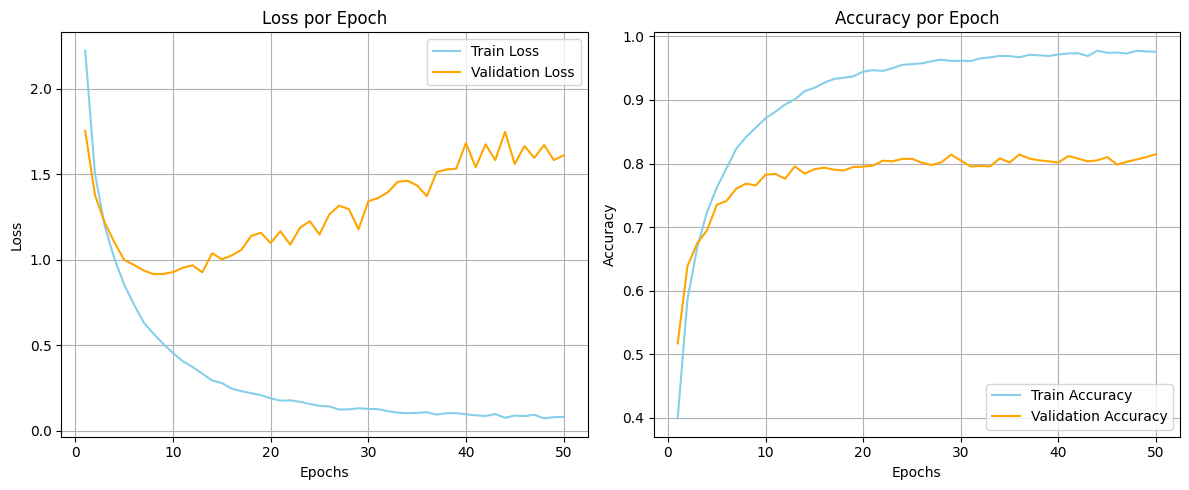

In [42]:
resumen = resumen_1_aug1

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

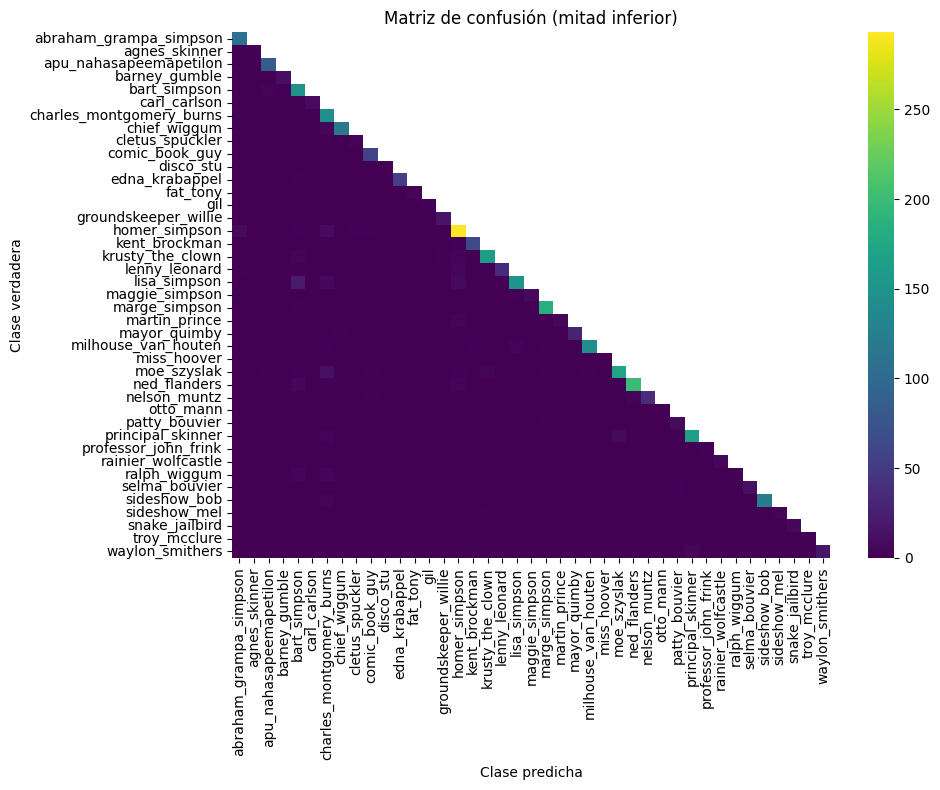

✅ Accuracy total en test: 81.92%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
marge_simpson              0.872642  0.953608  0.911330    194.0
sideshow_bob               0.884058  0.924242  0.903704    132.0
krusty_the_clown           0.909605  0.889503  0.899441    181.0
apu_nahasapeemapetilon     0.903226  0.893617  0.898396     94.0
milhouse_van_houten        0.910256  0.876543  0.893082    162.0
ned_flanders               0.858369  0.913242  0.884956    219.0
kent_brockman              0.822785  0.866667  0.844156     75.0
edna_krabappel             0.929825  0.768116  0.841270     69.0
principal_skinner          0.780952  0.911111  0.841026    180.0
homer_simpson              0.807163  0.869436  0.837143    337.0
comic_book_guy             0.840580  0.816901  0.828571     71.0
chief_wiggum               0.850000  0.804054  0.826389    148.0
lenny_leonard              0.897436  0.744681  0.813953     47.0
ab

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Evalúa en test
metricas_test_1_aug1 = test_model(modelo_entrenado_1_aug1, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug1).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

## Modelo 2 (CNN medio)

Partiendo de la estructura del modelo previo, en este nuevo modelo se explora una arquitectura más avanzada con más capas, para ver si el rendimiento puede verse mejorado.

### Entrenamiento

Se va a desarrollar una CNN más profunda y robusta que las CNN vistas anteriormente, con una arquitectura basada en dos partes principales:

---

1. `self.features` → Está compuesto por **9 capas en total**, organizadas en **3 bloques convolucionales**:

   - **Conv2D**: capas convolucionales que extraen patrones visuales. La primera convierte de 3 canales (RGB) a 32 mapas de características, la segunda de 32 a 64, y la tercera de 64 a 128. Todas usan filtros 3x3 con padding para mantener las dimensiones espaciales.
   
   - **BatchNorm2D**: normalización por lotes que estabiliza y acelera el entrenamiento al reducir la variación interna de las activaciones. Se aplica tras las dos primeras convoluciones.
   
   - **ReLU**: funciones de activación que mantienen los valores positivos y anulan los negativos, introduciendo no linealidad al modelo.
   
   - **MaxPool2D**: reducción espacial que disminuye el tamaño de las imágenes a la mitad después de los dos primeros bloques, conservando las características más importantes.
   
   - **AdaptiveAvgPool2D**: reduce cada mapa de activación de tamaño variable a un tamaño fijo de `(4, 4)`, permitiendo que la arquitectura sea más flexible ante distintas resoluciones de entrada.

   En conjunto, estos bloques procesan una imagen de entrada de tamaño `(3, 64, 64)` y la transforman en un tensor de tamaño fijo `(128, 4, 4)` al final de esta sección.

2. `self.classifier` → Está compuesto por **5 capas secuenciales**, encargadas de realizar la clasificación final a partir de las características extraídas:

   - **Flatten**: aplana el tensor de salida `(128, 4, 4)` en un vector de 2048 elementos para poder conectarlo con capas densas.
   
   - **Linear1 (Fully connected)**: reduce los 2048 valores a 256 neuronas intermedias, condensando la información.
   
   - **ReLU**: añade no linealidad entre capas densas para mejorar la capacidad de aprendizaje.
   
   - **Dropout**: desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento, reduciendo el riesgo de sobreajuste.
   
   - **Linear2 (Fully connected)**: transforma las 256 activaciones en `num_classes` salidas, correspondientes a las clases del problema.

   Este bloque toma la representación profunda obtenida por las convoluciones y la convierte en una predicción final de clase.

---

Este modelo es más potente que `SimpleCNN` ya que incorpora mayor profundidad, normalización, regularización y una mejor adaptación al tamaño de entrada, lo cual mejora su rendimiento en datasets complejos o desbalanceados.

In [44]:
#  Modelo CNN más profundo con batch normalization, dropout y adaptive pooling
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Inicializa una red convolucional más profunda que la SimpleCNN.

        :param num_classes: Número de clases de salida.
        """
        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1),              # Primer bloque: 3 canales RGB → 32 mapas de características (filtros 3x3, padding 1 mantiene tamaño: 64x64).
            nn.BatchNorm2d(32),                          # Normaliza las activaciones para estabilizar y acelerar el entrenamiento.
            nn.ReLU(),                                   # Función de activación ReLU para introducir no linealidad.
            nn.MaxPool2d(2),                             # Reduce las dimensiones espaciales a la mitad (64x64 → 32x32).

            nn.Conv2d(32, 64, 3, padding=1),             # Segundo bloque: 32 canales de entrada → 64 filtros 3x3 (tamaño permanece: 32x32).
            nn.BatchNorm2d(64),                          # Batch normalization sobre los 64 mapas de características.
            nn.ReLU(),                                   # Activación no lineal.
            nn.MaxPool2d(2),                             # Reduce tamaño a la mitad nuevamente (32x32 → 16x16).

            nn.Conv2d(64, 128, 3, padding=1),            # Tercer bloque: 64 → 128 filtros, mantiene dimensiones: 16x16.
            nn.ReLU(),                                   # Activación ReLU (sin batch norm esta vez).
            nn.AdaptiveAvgPool2d((4, 4))                 # Reduce dinámicamente cada mapa a tamaño fijo 4x4 (sin importar el tamaño de entrada exacto).
        )

        # Output de features: (128, 4, 4) → 128 canales de salida, cada uno de 4x4

        self.classifier = nn.Sequential(

            nn.Flatten(),                                # Aplana los tensores 128x4x4 en un vector de tamaño 2048 (128 * 4 * 4).
            nn.Linear(128 * 4 * 4, 256),                 # Capa totalmente conectada de 2048 → 256 neuronas.
            nn.ReLU(),                                   # Activación no lineal.
            nn.Dropout(0.5),                             # Desactiva aleatoriamente el 50% de las neuronas para reducir el sobreajuste.
            nn.Linear(256, num_classes)                  # Capa de salida que proyecta a `num_classes` (una salida por clase).

        )

        # Output final: vector 1D con `num_classes` elementos que representa las predicciones para cada clase

    def forward(self, x):
        """
        Método de propagación hacia adelante. Define cómo se transforma la entrada a través de la red.

        :param x: Tensor de entrada (batch de imágenes).
        :return: Tensor de salida (predicciones de clase).
        """
        x = self.features(x)                             # Pasa la entrada por las capas convolucionales + pooling + normalization.
        x = self.classifier(x)                           # Pasa el vector a través de las capas densas para obtener predicción final.
        return x                                         # Devuelve el resultado (logits por clase).


Se entrena el nuevo modelo, aplicando ajustes de Data Augmentation (dinámico) y sin realizar ajustes de balanceo sobre el criterio de pérdida. Esta configuración se ha visto que es la que mejor funciona.

In [45]:
# Volver a ejecutarlas para volver a tener un modelo desde 0 y evitar cache de lanzamientos previos
model_2 = DeepCNN(num_classes).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

# Entrena el modelo
modelo_entrenado_2, resumen_2 = train_model(model_2, train_loader_aug1, val_loader, criterion_2, optimizer_2, epochs=100)

Época 1/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 2.5855 | Accuracy: 28.65%
🔍 Validación — Loss: 1.9860 | Accuracy: 46.15%



Época 2/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 1.9973 | Accuracy: 44.80%
🔍 Validación — Loss: 1.6318 | Accuracy: 54.81%



Época 3/100: 100%|██████████| 458/458 [00:41<00:00, 11.11it/s]



✅ Entrenamiento — Loss: 1.7347 | Accuracy: 52.33%
🔍 Validación — Loss: 1.4270 | Accuracy: 61.62%



Época 4/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 1.5116 | Accuracy: 57.54%
🔍 Validación — Loss: 1.3593 | Accuracy: 62.42%



Época 5/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 1.3696 | Accuracy: 61.44%
🔍 Validación — Loss: 1.1128 | Accuracy: 68.38%



Época 6/100: 100%|██████████| 458/458 [00:41<00:00, 11.11it/s]



✅ Entrenamiento — Loss: 1.2541 | Accuracy: 64.34%
🔍 Validación — Loss: 1.0525 | Accuracy: 69.20%



Época 7/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 1.1363 | Accuracy: 67.38%
🔍 Validación — Loss: 0.9587 | Accuracy: 72.45%



Época 8/100: 100%|██████████| 458/458 [00:40<00:00, 11.19it/s]



✅ Entrenamiento — Loss: 1.0517 | Accuracy: 69.69%
🔍 Validación — Loss: 0.9028 | Accuracy: 75.06%



Época 9/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.9817 | Accuracy: 71.80%
🔍 Validación — Loss: 0.8054 | Accuracy: 76.46%



Época 10/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.9189 | Accuracy: 73.45%
🔍 Validación — Loss: 0.7798 | Accuracy: 77.90%



Época 11/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.8486 | Accuracy: 75.31%
🔍 Validación — Loss: 0.7789 | Accuracy: 78.18%



Época 12/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.8151 | Accuracy: 76.43%
🔍 Validación — Loss: 0.7462 | Accuracy: 79.52%



Época 13/100: 100%|██████████| 458/458 [00:41<00:00, 11.13it/s]



✅ Entrenamiento — Loss: 0.7700 | Accuracy: 77.79%
🔍 Validación — Loss: 0.6927 | Accuracy: 81.05%



Época 14/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.7264 | Accuracy: 78.73%
🔍 Validación — Loss: 0.6730 | Accuracy: 81.11%



Época 15/100: 100%|██████████| 458/458 [00:40<00:00, 11.22it/s]



✅ Entrenamiento — Loss: 0.7007 | Accuracy: 79.92%
🔍 Validación — Loss: 0.6558 | Accuracy: 82.52%



Época 16/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.6586 | Accuracy: 80.60%
🔍 Validación — Loss: 0.6248 | Accuracy: 83.22%



Época 17/100: 100%|██████████| 458/458 [00:41<00:00, 11.09it/s]



✅ Entrenamiento — Loss: 0.6243 | Accuracy: 81.81%
🔍 Validación — Loss: 0.6481 | Accuracy: 82.45%



Época 18/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.5980 | Accuracy: 82.54%
🔍 Validación — Loss: 0.5975 | Accuracy: 84.46%



Época 19/100: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.5855 | Accuracy: 82.92%
🔍 Validación — Loss: 0.6380 | Accuracy: 83.41%



Época 20/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.5504 | Accuracy: 83.99%
🔍 Validación — Loss: 0.6004 | Accuracy: 85.06%



Época 21/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.5322 | Accuracy: 84.27%
🔍 Validación — Loss: 0.5920 | Accuracy: 84.97%



Época 22/100: 100%|██████████| 458/458 [00:40<00:00, 11.23it/s]



✅ Entrenamiento — Loss: 0.5062 | Accuracy: 85.56%
🔍 Validación — Loss: 0.5404 | Accuracy: 86.40%



Época 23/100: 100%|██████████| 458/458 [00:41<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.4894 | Accuracy: 85.65%
🔍 Validación — Loss: 0.5675 | Accuracy: 85.54%



Época 24/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.4803 | Accuracy: 85.97%
🔍 Validación — Loss: 0.5496 | Accuracy: 86.50%



Época 25/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.4602 | Accuracy: 86.49%
🔍 Validación — Loss: 0.5347 | Accuracy: 87.20%



Época 26/100: 100%|██████████| 458/458 [00:40<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.4415 | Accuracy: 87.05%
🔍 Validación — Loss: 0.5040 | Accuracy: 88.06%



Época 27/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.4375 | Accuracy: 86.99%
🔍 Validación — Loss: 0.5268 | Accuracy: 87.74%



Época 28/100: 100%|██████████| 458/458 [00:40<00:00, 11.23it/s]



✅ Entrenamiento — Loss: 0.4122 | Accuracy: 87.63%
🔍 Validación — Loss: 0.5231 | Accuracy: 86.85%



Época 29/100: 100%|██████████| 458/458 [00:40<00:00, 11.20it/s]



✅ Entrenamiento — Loss: 0.4176 | Accuracy: 87.43%
🔍 Validación — Loss: 0.5250 | Accuracy: 87.55%



Época 30/100: 100%|██████████| 458/458 [00:40<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.3957 | Accuracy: 88.20%
🔍 Validación — Loss: 0.5089 | Accuracy: 87.93%



Época 31/100: 100%|██████████| 458/458 [00:40<00:00, 11.21it/s]



✅ Entrenamiento — Loss: 0.3964 | Accuracy: 88.26%
🔍 Validación — Loss: 0.4981 | Accuracy: 88.54%



Época 32/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.3734 | Accuracy: 88.78%
🔍 Validación — Loss: 0.4972 | Accuracy: 88.15%



Época 33/100: 100%|██████████| 458/458 [00:41<00:00, 11.05it/s]



✅ Entrenamiento — Loss: 0.3626 | Accuracy: 89.24%
🔍 Validación — Loss: 0.5270 | Accuracy: 87.99%



Época 34/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.3661 | Accuracy: 88.91%
🔍 Validación — Loss: 0.5460 | Accuracy: 87.20%



Época 35/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.3464 | Accuracy: 89.49%
🔍 Validación — Loss: 0.5313 | Accuracy: 88.09%



Época 36/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.3395 | Accuracy: 89.78%
🔍 Validación — Loss: 0.5255 | Accuracy: 88.03%



Época 37/100: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.3238 | Accuracy: 90.19%
🔍 Validación — Loss: 0.5113 | Accuracy: 88.09%



Época 38/100: 100%|██████████| 458/458 [00:41<00:00, 11.08it/s]



✅ Entrenamiento — Loss: 0.3343 | Accuracy: 89.84%
🔍 Validación — Loss: 0.5272 | Accuracy: 88.54%



Época 39/100: 100%|██████████| 458/458 [00:41<00:00, 11.05it/s]



✅ Entrenamiento — Loss: 0.3050 | Accuracy: 90.57%
🔍 Validación — Loss: 0.5171 | Accuracy: 88.69%



Época 40/100: 100%|██████████| 458/458 [00:41<00:00, 11.01it/s]



✅ Entrenamiento — Loss: 0.3101 | Accuracy: 90.44%
🔍 Validación — Loss: 0.5176 | Accuracy: 88.57%



Época 41/100: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.2993 | Accuracy: 91.05%
🔍 Validación — Loss: 0.5513 | Accuracy: 88.22%



Época 42/100: 100%|██████████| 458/458 [00:41<00:00, 11.08it/s]



✅ Entrenamiento — Loss: 0.2916 | Accuracy: 91.07%
🔍 Validación — Loss: 0.5224 | Accuracy: 89.24%



Época 43/100: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.2985 | Accuracy: 91.08%
🔍 Validación — Loss: 0.5206 | Accuracy: 88.92%



Época 44/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.2721 | Accuracy: 91.59%
🔍 Validación — Loss: 0.4881 | Accuracy: 89.59%



Época 45/100: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.2807 | Accuracy: 91.68%
🔍 Validación — Loss: 0.5198 | Accuracy: 88.92%



Época 46/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.2797 | Accuracy: 91.65%
🔍 Validación — Loss: 0.5380 | Accuracy: 89.43%



Época 47/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.2749 | Accuracy: 91.51%
🔍 Validación — Loss: 0.5165 | Accuracy: 89.46%



Época 48/100: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.2698 | Accuracy: 91.85%
🔍 Validación — Loss: 0.5440 | Accuracy: 89.14%



Época 49/100: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.2613 | Accuracy: 91.98%
🔍 Validación — Loss: 0.5041 | Accuracy: 88.98%



Época 50/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.2593 | Accuracy: 91.95%
🔍 Validación — Loss: 0.5217 | Accuracy: 89.36%



Época 51/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.2590 | Accuracy: 92.14%
🔍 Validación — Loss: 0.5200 | Accuracy: 89.24%



Época 52/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.2312 | Accuracy: 92.58%
🔍 Validación — Loss: 0.5392 | Accuracy: 89.39%



Época 53/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2481 | Accuracy: 92.45%
🔍 Validación — Loss: 0.5295 | Accuracy: 89.17%



Época 54/100: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.2357 | Accuracy: 92.66%
🔍 Validación — Loss: 0.5258 | Accuracy: 89.30%



Época 55/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2348 | Accuracy: 92.96%
🔍 Validación — Loss: 0.5500 | Accuracy: 89.39%



Época 56/100: 100%|██████████| 458/458 [00:41<00:00, 11.11it/s]



✅ Entrenamiento — Loss: 0.2213 | Accuracy: 93.19%
🔍 Validación — Loss: 0.5836 | Accuracy: 89.46%



Época 57/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.2305 | Accuracy: 92.86%
🔍 Validación — Loss: 0.5342 | Accuracy: 89.65%



Época 58/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2266 | Accuracy: 92.84%
🔍 Validación — Loss: 0.5659 | Accuracy: 89.14%



Época 59/100: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.2294 | Accuracy: 92.88%
🔍 Validación — Loss: 0.5445 | Accuracy: 90.06%



Época 60/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2253 | Accuracy: 93.14%
🔍 Validación — Loss: 0.5438 | Accuracy: 90.41%



Época 61/100: 100%|██████████| 458/458 [00:41<00:00, 11.02it/s]



✅ Entrenamiento — Loss: 0.2229 | Accuracy: 93.03%
🔍 Validación — Loss: 0.5600 | Accuracy: 89.65%



Época 62/100: 100%|██████████| 458/458 [00:41<00:00, 11.01it/s]



✅ Entrenamiento — Loss: 0.2218 | Accuracy: 93.09%
🔍 Validación — Loss: 0.5442 | Accuracy: 90.13%



Época 63/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2110 | Accuracy: 93.32%
🔍 Validación — Loss: 0.5386 | Accuracy: 90.32%



Época 64/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.1930 | Accuracy: 93.90%
🔍 Validación — Loss: 0.5619 | Accuracy: 89.81%



Época 65/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.2114 | Accuracy: 93.70%
🔍 Validación — Loss: 0.5511 | Accuracy: 89.49%



Época 66/100: 100%|██████████| 458/458 [00:41<00:00, 10.97it/s]



✅ Entrenamiento — Loss: 0.1934 | Accuracy: 94.07%
🔍 Validación — Loss: 0.5719 | Accuracy: 89.84%



Época 67/100: 100%|██████████| 458/458 [00:41<00:00, 10.96it/s]



✅ Entrenamiento — Loss: 0.2029 | Accuracy: 93.71%
🔍 Validación — Loss: 0.5774 | Accuracy: 89.46%



Época 68/100: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.1964 | Accuracy: 93.86%
🔍 Validación — Loss: 0.5366 | Accuracy: 89.84%



Época 69/100: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 0.1873 | Accuracy: 94.46%
🔍 Validación — Loss: 0.5866 | Accuracy: 90.13%



Época 70/100: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 0.1955 | Accuracy: 93.75%
🔍 Validación — Loss: 0.5874 | Accuracy: 89.62%



Época 71/100: 100%|██████████| 458/458 [00:41<00:00, 11.02it/s]



✅ Entrenamiento — Loss: 0.1895 | Accuracy: 94.20%
🔍 Validación — Loss: 0.5498 | Accuracy: 89.87%



Época 72/100: 100%|██████████| 458/458 [00:41<00:00, 11.05it/s]



✅ Entrenamiento — Loss: 0.1907 | Accuracy: 94.10%
🔍 Validación — Loss: 0.5636 | Accuracy: 90.76%



Época 73/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.1876 | Accuracy: 94.16%
🔍 Validación — Loss: 0.5619 | Accuracy: 90.16%



Época 74/100: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 0.1916 | Accuracy: 94.01%
🔍 Validación — Loss: 0.5307 | Accuracy: 90.92%



Época 75/100: 100%|██████████| 458/458 [00:41<00:00, 11.10it/s]



✅ Entrenamiento — Loss: 0.1747 | Accuracy: 94.58%
🔍 Validación — Loss: 0.5240 | Accuracy: 90.57%



Época 76/100: 100%|██████████| 458/458 [00:41<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1848 | Accuracy: 94.06%
🔍 Validación — Loss: 0.5390 | Accuracy: 90.54%



Época 77/100: 100%|██████████| 458/458 [00:41<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1711 | Accuracy: 94.79%
🔍 Validación — Loss: 0.5618 | Accuracy: 89.59%



Época 78/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.1770 | Accuracy: 94.44%
🔍 Validación — Loss: 0.5575 | Accuracy: 90.92%



Época 79/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.1636 | Accuracy: 94.90%
🔍 Validación — Loss: 0.5811 | Accuracy: 90.51%



Época 80/100: 100%|██████████| 458/458 [00:41<00:00, 11.13it/s]



✅ Entrenamiento — Loss: 0.1722 | Accuracy: 94.70%
🔍 Validación — Loss: 0.5481 | Accuracy: 90.61%



Época 81/100: 100%|██████████| 458/458 [00:40<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1784 | Accuracy: 94.61%
🔍 Validación — Loss: 0.5832 | Accuracy: 90.10%



Época 82/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.1697 | Accuracy: 94.70%
🔍 Validación — Loss: 0.5610 | Accuracy: 90.67%



Época 83/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.1665 | Accuracy: 94.92%
🔍 Validación — Loss: 0.5580 | Accuracy: 90.80%



Época 84/100: 100%|██████████| 458/458 [00:41<00:00, 11.16it/s]



✅ Entrenamiento — Loss: 0.1606 | Accuracy: 94.87%
🔍 Validación — Loss: 0.5771 | Accuracy: 90.67%



Época 85/100: 100%|██████████| 458/458 [00:40<00:00, 11.19it/s]



✅ Entrenamiento — Loss: 0.1563 | Accuracy: 95.22%
🔍 Validación — Loss: 0.5555 | Accuracy: 90.80%



Época 86/100: 100%|██████████| 458/458 [00:40<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1650 | Accuracy: 95.12%
🔍 Validación — Loss: 0.6056 | Accuracy: 90.22%



Época 87/100: 100%|██████████| 458/458 [00:41<00:00, 11.13it/s]



✅ Entrenamiento — Loss: 0.1674 | Accuracy: 94.76%
🔍 Validación — Loss: 0.5477 | Accuracy: 91.15%



Época 88/100: 100%|██████████| 458/458 [00:41<00:00, 11.13it/s]



✅ Entrenamiento — Loss: 0.1506 | Accuracy: 95.13%
🔍 Validación — Loss: 0.6006 | Accuracy: 90.06%



Época 89/100: 100%|██████████| 458/458 [00:40<00:00, 11.19it/s]



✅ Entrenamiento — Loss: 0.1665 | Accuracy: 94.97%
🔍 Validación — Loss: 0.5934 | Accuracy: 90.25%



Época 90/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.1616 | Accuracy: 94.91%
🔍 Validación — Loss: 0.5948 | Accuracy: 90.48%



Época 91/100: 100%|██████████| 458/458 [00:40<00:00, 11.18it/s]



✅ Entrenamiento — Loss: 0.1559 | Accuracy: 95.11%
🔍 Validación — Loss: 0.5888 | Accuracy: 90.61%



Época 92/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.1508 | Accuracy: 95.48%
🔍 Validación — Loss: 0.5910 | Accuracy: 90.41%



Época 93/100: 100%|██████████| 458/458 [00:41<00:00, 11.15it/s]



✅ Entrenamiento — Loss: 0.1420 | Accuracy: 95.41%
🔍 Validación — Loss: 0.5740 | Accuracy: 90.73%



Época 94/100: 100%|██████████| 458/458 [00:41<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1487 | Accuracy: 95.40%
🔍 Validación — Loss: 0.5718 | Accuracy: 91.27%



Época 95/100: 100%|██████████| 458/458 [00:41<00:00, 11.17it/s]



✅ Entrenamiento — Loss: 0.1529 | Accuracy: 95.30%
🔍 Validación — Loss: 0.6006 | Accuracy: 90.70%



Época 96/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.1574 | Accuracy: 95.09%
🔍 Validación — Loss: 0.5817 | Accuracy: 90.61%



Época 97/100: 100%|██████████| 458/458 [00:41<00:00, 11.14it/s]



✅ Entrenamiento — Loss: 0.1418 | Accuracy: 95.45%
🔍 Validación — Loss: 0.6189 | Accuracy: 90.73%



Época 98/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.1476 | Accuracy: 95.52%
🔍 Validación — Loss: 0.6669 | Accuracy: 89.65%



Época 99/100: 100%|██████████| 458/458 [00:41<00:00, 11.12it/s]



✅ Entrenamiento — Loss: 0.1503 | Accuracy: 95.32%
🔍 Validación — Loss: 0.5945 | Accuracy: 90.80%



Época 100/100: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 0.1578 | Accuracy: 95.33%
🔍 Validación — Loss: 0.5557 | Accuracy: 90.41%



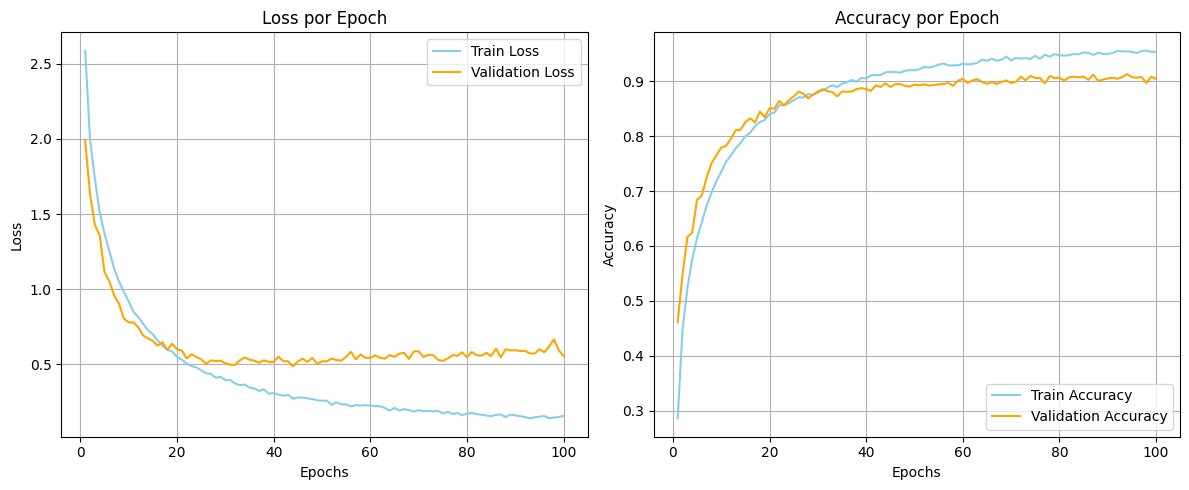

In [46]:
resumen = resumen_2

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

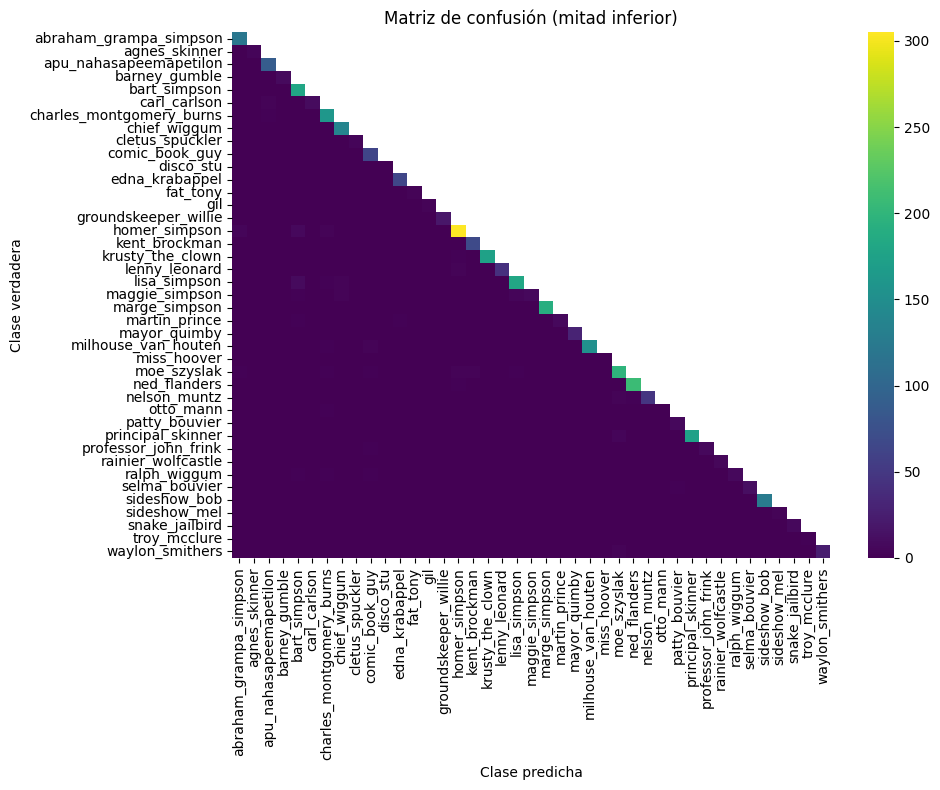

✅ Accuracy total en test: 90.25%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
troy_mcclure               1.000000  1.000000  1.000000      2.0
marge_simpson              0.945545  0.984536  0.964646    194.0
sideshow_bob               0.954545  0.954545  0.954545    132.0
principal_skinner          0.945355  0.961111  0.953168    180.0
krusty_the_clown           0.935829  0.966851  0.951087    181.0
milhouse_van_houten        0.962025  0.938272  0.950000    162.0
groundskeeper_willie       0.947368  0.947368  0.947368     19.0
apu_nahasapeemapetilon     0.927083  0.946809  0.936842     94.0
ned_flanders               0.920354  0.949772  0.934831    219.0
kent_brockman              0.932432  0.920000  0.926174     75.0
chief_wiggum               0.902597  0.939189  0.920530    148.0
lisa_simpson               0.947917  0.892157  0.919192    204.0
waylon_smithers            0.960000  0.857143  0.905660     28.0
ab

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Evalúa en test
metricas_test_2 = test_model(modelo_entrenado_2, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_2).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

In [48]:
del modelo_entrenado_2
del criterion_2
del optimizer_2

## Modelo 3 (CNN avanzado)

### Entrenamiento

Se va a desarrollar una CNN todavía más profunda y potente que las anteriores, inspirada en arquitecturas como **VGG**, con una estructura modular que facilita la extracción jerárquica de características. El modelo se divide en dos partes principales:

---

1. `self.features` → Compuesta por **14 capas convolucionales y de activación**, organizadas en **4 bloques convolucionales**:

Cada bloque contiene dos capas convolucionales `Conv2D`, seguidas por `BatchNorm2D`, `ReLU` y una capa de pooling. El último bloque finaliza con un `AdaptiveAvgPool2D` para obtener una salida de tamaño fijo:

- **Bloque 1**:
  - Conv2D: 3 canales RGB → 64 filtros, luego otra Conv2D de 64 → 64.
  - BatchNorm2D y ReLU tras cada conv.
  - MaxPool2D: reduce de 64x64 a 32x32.

- **Bloque 2**:
  - Conv2D: 64 → 128 → 128.
  - BatchNorm2D y ReLU en ambas.
  - MaxPool2D: 32x32 → 16x16.

- **Bloque 3**:
  - Conv2D: 128 → 256 → 256.
  - BatchNorm2D + ReLU.
  - MaxPool2D: 16x16 → 8x8.

- **Bloque 4**:
  - Conv2D: 256 → 512 → 512.
  - BatchNorm2D + ReLU.
  - AdaptiveAvgPool2D: reduce dinámicamente a tamaño fijo `(4, 4)` por canal.

Esta parte toma una imagen de entrada de forma `(3, 64, 64)` y la convierte en un tensor de forma `(512, 4, 4)`, equivalente a 8192 características profundas extraídas.

---

2. `self.classifier` → Compuesto por **7 capas secuenciales** que realizan la clasificación a partir de las características extraídas:

- **Flatten**: convierte el tensor `(512, 4, 4)` en un vector de tamaño `8192`.
- **Linear1**: mapea de 8192 a 512 neuronas.
- **ReLU**: añade no linealidad.
- **Dropout (0.5)**: reduce el sobreajuste al desactivar aleatoriamente la mitad de las neuronas.
- **Linear2**: reduce de 512 a 256 neuronas.
- **ReLU + Dropout (0.5)**: añade robustez y evita overfitting.
- **Linear final**: genera una salida de tamaño `num_classes`, correspondiente a la cantidad de clases del problema.

---

Este modelo mejora significativamente a `DeepCNN` al incorporar:

- Mayor **profundidad y capacidad de representación**.
- **Batch normalization** tras cada convolución para estabilidad.
- **Dropout doble** en la parte densa para regularización.
- **Pooling adaptable** para trabajar con imágenes de entrada flexibles.

Está diseñado para lograr alto rendimiento en tareas de clasificación de imágenes complejas.

In [49]:
# Modelo CNN aún más profundo con múltiples bloques convolucionales, batch normalization y dropout
class VeryDeepCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Inicializa una red convolucional profunda con varios bloques, similar a VGG.

        :param num_classes: Número de clases de salida.
        """
        super().__init__()

        self.features = nn.Sequential(

            # Primer bloque convolucional: entrada RGB → 64 filtros
            nn.Conv2d(3, 64, 3, padding=1),              # Filtros 3x3, padding 1 mantiene tamaño: 64x64
            nn.BatchNorm2d(64),                          # Normalización de activaciones
            nn.ReLU(),                                   # Activación ReLU
            nn.Conv2d(64, 64, 3, padding=1),             # Segundo conv del bloque (64x64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Reducción espacial: 64x64 → 32x32

            # Segundo bloque convolucional: 64 → 128 filtros
            nn.Conv2d(64, 128, 3, padding=1),            # Tamaño se mantiene: 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 32x32 → 16x16

            # Tercer bloque convolucional: 128 → 256 filtros
            nn.Conv2d(128, 256, 3, padding=1),           # Tamaño se mantiene: 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 16x16 → 8x8

            # Cuarto bloque convolucional: 256 → 512 filtros
            nn.Conv2d(256, 512, 3, padding=1),           # Mantiene tamaño: 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))                 # Reducción adaptable a tamaño fijo: 4x4 por canal (512 x 4 x 4)
        )

        # Salida de la sección convolucional: (512, 4, 4) = 8192 elementos

        self.classifier = nn.Sequential(

            nn.Flatten(),                                # Convierte tensor 512x4x4 en vector de 8192
            nn.Linear(512 * 4 * 4, 512),                 # Primera capa densa: 8192 → 512
            nn.ReLU(),                                   # Activación ReLU
            nn.Dropout(0.5),                             # Dropout 50% para combatir el sobreajuste

            nn.Linear(512, 256),                         # Segunda capa densa: 512 → 256
            nn.ReLU(),                                   # Activación ReLU
            nn.Dropout(0.5),                             # Otro dropout

            nn.Linear(256, num_classes)                  # Capa final: 256 → número de clases
        )

    def forward(self, x):
        """
        Método de propagación hacia adelante. Define cómo se transforma la entrada a través de la red.

        :param x: Tensor de entrada (batch de imágenes).
        :return: Tensor de salida (predicciones de clase).
        """
        x = self.features(x)                             # Pasa la entrada por capas convolucionales
        x = self.classifier(x)                           # Clasifica usando capas densas
        return x                                          # Devuelve logits (una predicción por clase)


In [50]:
# Volver a ejecutarlas para volver a tener un modelo desde 0 y evitar cache de lanzamientos previos
model_3 = VeryDeepCNN(num_classes).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)

# Entrena el modelo
modelo_entrenado_3, resumen_3 = train_model(model_3, train_loader_aug1, val_loader, criterion_3, optimizer_3, epochs=100)

Época 1/100: 100%|██████████| 458/458 [00:46<00:00,  9.75it/s]



✅ Entrenamiento — Loss: 3.1125 | Accuracy: 11.26%
🔍 Validación — Loss: 2.7683 | Accuracy: 22.71%



Época 2/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 2.7835 | Accuracy: 21.14%
🔍 Validación — Loss: 2.4874 | Accuracy: 29.17%



Época 3/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 2.4932 | Accuracy: 27.94%
🔍 Validación — Loss: 2.2365 | Accuracy: 37.04%



Época 4/100: 100%|██████████| 458/458 [00:46<00:00,  9.75it/s]



✅ Entrenamiento — Loss: 2.2348 | Accuracy: 34.19%
🔍 Validación — Loss: 1.9440 | Accuracy: 43.28%



Época 5/100: 100%|██████████| 458/458 [00:47<00:00,  9.72it/s]



✅ Entrenamiento — Loss: 2.0057 | Accuracy: 41.26%
🔍 Validación — Loss: 1.8409 | Accuracy: 47.04%



Época 6/100: 100%|██████████| 458/458 [00:47<00:00,  9.72it/s]



✅ Entrenamiento — Loss: 1.7842 | Accuracy: 47.85%
🔍 Validación — Loss: 1.5056 | Accuracy: 55.22%



Época 7/100: 100%|██████████| 458/458 [00:47<00:00,  9.67it/s]



✅ Entrenamiento — Loss: 1.5925 | Accuracy: 53.54%
🔍 Validación — Loss: 1.2441 | Accuracy: 61.94%



Época 8/100: 100%|██████████| 458/458 [00:46<00:00,  9.77it/s]



✅ Entrenamiento — Loss: 1.4617 | Accuracy: 56.74%
🔍 Validación — Loss: 1.1238 | Accuracy: 67.58%



Época 9/100: 100%|██████████| 458/458 [00:47<00:00,  9.72it/s]



✅ Entrenamiento — Loss: 1.3303 | Accuracy: 61.38%
🔍 Validación — Loss: 1.1863 | Accuracy: 66.53%



Época 10/100: 100%|██████████| 458/458 [00:47<00:00,  9.66it/s]



✅ Entrenamiento — Loss: 1.2407 | Accuracy: 64.09%
🔍 Validación — Loss: 1.0430 | Accuracy: 70.38%



Época 11/100: 100%|██████████| 458/458 [00:47<00:00,  9.70it/s]



✅ Entrenamiento — Loss: 1.1319 | Accuracy: 67.44%
🔍 Validación — Loss: 0.9682 | Accuracy: 71.94%



Época 12/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 1.0713 | Accuracy: 69.37%
🔍 Validación — Loss: 0.8453 | Accuracy: 77.07%



Época 13/100: 100%|██████████| 458/458 [00:46<00:00,  9.77it/s]



✅ Entrenamiento — Loss: 0.9944 | Accuracy: 71.69%
🔍 Validación — Loss: 0.8571 | Accuracy: 77.68%



Época 14/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.9506 | Accuracy: 73.21%
🔍 Validación — Loss: 0.7474 | Accuracy: 80.10%



Época 15/100: 100%|██████████| 458/458 [00:46<00:00,  9.78it/s]



✅ Entrenamiento — Loss: 0.8783 | Accuracy: 75.98%
🔍 Validación — Loss: 0.8202 | Accuracy: 78.47%



Época 16/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.8112 | Accuracy: 77.65%
🔍 Validación — Loss: 0.7473 | Accuracy: 80.96%



Época 17/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 0.7739 | Accuracy: 79.24%
🔍 Validación — Loss: 0.6084 | Accuracy: 84.62%



Época 18/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 0.7294 | Accuracy: 80.51%
🔍 Validación — Loss: 0.6136 | Accuracy: 84.75%



Época 19/100: 100%|██████████| 458/458 [00:47<00:00,  9.70it/s]



✅ Entrenamiento — Loss: 0.6800 | Accuracy: 81.42%
🔍 Validación — Loss: 0.6532 | Accuracy: 82.90%



Época 20/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 0.6543 | Accuracy: 82.48%
🔍 Validación — Loss: 0.5700 | Accuracy: 85.22%



Época 21/100: 100%|██████████| 458/458 [00:46<00:00,  9.76it/s]



✅ Entrenamiento — Loss: 0.6175 | Accuracy: 83.37%
🔍 Validación — Loss: 0.5882 | Accuracy: 84.68%



Época 22/100: 100%|██████████| 458/458 [00:47<00:00,  9.73it/s]



✅ Entrenamiento — Loss: 0.5681 | Accuracy: 84.77%
🔍 Validación — Loss: 0.5327 | Accuracy: 86.46%



Época 23/100: 100%|██████████| 458/458 [00:46<00:00,  9.76it/s]



✅ Entrenamiento — Loss: 0.5440 | Accuracy: 85.24%
🔍 Validación — Loss: 0.5724 | Accuracy: 85.80%



Época 24/100: 100%|██████████| 458/458 [00:47<00:00,  9.73it/s]



✅ Entrenamiento — Loss: 0.5003 | Accuracy: 86.59%
🔍 Validación — Loss: 0.5257 | Accuracy: 86.97%



Época 25/100: 100%|██████████| 458/458 [00:46<00:00,  9.75it/s]



✅ Entrenamiento — Loss: 0.4719 | Accuracy: 86.90%
🔍 Validación — Loss: 0.4786 | Accuracy: 88.22%



Época 26/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.4485 | Accuracy: 87.75%
🔍 Validación — Loss: 0.4749 | Accuracy: 88.06%



Época 27/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.4299 | Accuracy: 88.13%
🔍 Validación — Loss: 0.4698 | Accuracy: 87.96%



Época 28/100: 100%|██████████| 458/458 [00:46<00:00,  9.77it/s]



✅ Entrenamiento — Loss: 0.4148 | Accuracy: 88.39%
🔍 Validación — Loss: 0.5057 | Accuracy: 88.06%



Época 29/100: 100%|██████████| 458/458 [00:46<00:00,  9.86it/s]



✅ Entrenamiento — Loss: 0.3961 | Accuracy: 89.13%
🔍 Validación — Loss: 0.5559 | Accuracy: 87.74%



Época 30/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.3639 | Accuracy: 89.84%
🔍 Validación — Loss: 0.4449 | Accuracy: 89.46%



Época 31/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.3462 | Accuracy: 90.32%
🔍 Validación — Loss: 0.4644 | Accuracy: 88.98%



Época 32/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.3321 | Accuracy: 90.88%
🔍 Validación — Loss: 0.4587 | Accuracy: 90.03%



Época 33/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.3117 | Accuracy: 91.06%
🔍 Validación — Loss: 0.4515 | Accuracy: 90.19%



Época 34/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.3060 | Accuracy: 91.33%
🔍 Validación — Loss: 0.4314 | Accuracy: 90.41%



Época 35/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.2877 | Accuracy: 91.97%
🔍 Validación — Loss: 0.4233 | Accuracy: 91.31%



Época 36/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.2766 | Accuracy: 92.35%
🔍 Validación — Loss: 0.4071 | Accuracy: 91.59%



Época 37/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.2572 | Accuracy: 92.99%
🔍 Validación — Loss: 0.4706 | Accuracy: 90.67%



Época 38/100: 100%|██████████| 458/458 [00:46<00:00,  9.85it/s]



✅ Entrenamiento — Loss: 0.2539 | Accuracy: 92.58%
🔍 Validación — Loss: 0.4729 | Accuracy: 90.57%



Época 39/100: 100%|██████████| 458/458 [00:46<00:00,  9.85it/s]



✅ Entrenamiento — Loss: 0.2551 | Accuracy: 93.00%
🔍 Validación — Loss: 0.4169 | Accuracy: 91.82%



Época 40/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.2476 | Accuracy: 93.19%
🔍 Validación — Loss: 0.4176 | Accuracy: 91.56%



Época 41/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.2285 | Accuracy: 93.58%
🔍 Validación — Loss: 0.4649 | Accuracy: 90.29%



Época 42/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.2081 | Accuracy: 94.25%
🔍 Validación — Loss: 0.4477 | Accuracy: 91.75%



Época 43/100: 100%|██████████| 458/458 [00:46<00:00,  9.87it/s]



✅ Entrenamiento — Loss: 0.2041 | Accuracy: 94.23%
🔍 Validación — Loss: 0.4705 | Accuracy: 91.21%



Época 44/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.2046 | Accuracy: 94.37%
🔍 Validación — Loss: 0.4255 | Accuracy: 91.88%



Época 45/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.1863 | Accuracy: 94.76%
🔍 Validación — Loss: 0.4264 | Accuracy: 91.85%



Época 46/100: 100%|██████████| 458/458 [00:47<00:00,  9.73it/s]



✅ Entrenamiento — Loss: 0.1941 | Accuracy: 94.72%
🔍 Validación — Loss: 0.4068 | Accuracy: 92.39%



Época 47/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.1691 | Accuracy: 95.39%
🔍 Validación — Loss: 0.4264 | Accuracy: 91.88%



Época 48/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.1724 | Accuracy: 95.15%
🔍 Validación — Loss: 0.4447 | Accuracy: 91.75%



Época 49/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.1703 | Accuracy: 95.13%
🔍 Validación — Loss: 0.4719 | Accuracy: 92.10%



Época 50/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.1584 | Accuracy: 95.36%
🔍 Validación — Loss: 0.3888 | Accuracy: 92.74%



Época 51/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.1674 | Accuracy: 95.43%
🔍 Validación — Loss: 0.4494 | Accuracy: 92.48%



Época 52/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.1367 | Accuracy: 96.03%
🔍 Validación — Loss: 0.4754 | Accuracy: 92.23%



Época 53/100: 100%|██████████| 458/458 [00:46<00:00,  9.86it/s]



✅ Entrenamiento — Loss: 0.1353 | Accuracy: 96.19%
🔍 Validación — Loss: 0.4818 | Accuracy: 92.52%



Época 54/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.1359 | Accuracy: 96.19%
🔍 Validación — Loss: 0.4508 | Accuracy: 92.55%



Época 55/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.1237 | Accuracy: 96.66%
🔍 Validación — Loss: 0.5309 | Accuracy: 92.71%



Época 56/100: 100%|██████████| 458/458 [00:46<00:00,  9.85it/s]



✅ Entrenamiento — Loss: 0.1424 | Accuracy: 96.04%
🔍 Validación — Loss: 0.4475 | Accuracy: 92.71%



Época 57/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.1177 | Accuracy: 96.82%
🔍 Validación — Loss: 0.5165 | Accuracy: 91.62%



Época 58/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.1331 | Accuracy: 96.46%
🔍 Validación — Loss: 0.4299 | Accuracy: 92.58%



Época 59/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.1201 | Accuracy: 96.76%
🔍 Validación — Loss: 0.4865 | Accuracy: 92.74%



Época 60/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.1140 | Accuracy: 96.89%
🔍 Validación — Loss: 0.4878 | Accuracy: 92.90%



Época 61/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.1270 | Accuracy: 96.45%
🔍 Validación — Loss: 0.4741 | Accuracy: 92.20%



Época 62/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.0944 | Accuracy: 97.35%
🔍 Validación — Loss: 0.4960 | Accuracy: 92.55%



Época 63/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.0971 | Accuracy: 97.18%
🔍 Validación — Loss: 0.5383 | Accuracy: 92.10%



Época 64/100: 100%|██████████| 458/458 [00:46<00:00,  9.85it/s]



✅ Entrenamiento — Loss: 0.1354 | Accuracy: 96.52%
🔍 Validación — Loss: 0.4405 | Accuracy: 93.03%



Época 65/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0988 | Accuracy: 97.08%
🔍 Validación — Loss: 0.5435 | Accuracy: 93.22%



Época 66/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0968 | Accuracy: 97.35%
🔍 Validación — Loss: 0.5397 | Accuracy: 92.45%



Época 67/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0990 | Accuracy: 97.25%
🔍 Validación — Loss: 0.5151 | Accuracy: 92.29%



Época 68/100: 100%|██████████| 458/458 [00:46<00:00,  9.86it/s]



✅ Entrenamiento — Loss: 0.0897 | Accuracy: 97.55%
🔍 Validación — Loss: 0.4919 | Accuracy: 93.25%



Época 69/100: 100%|██████████| 458/458 [00:46<00:00,  9.87it/s]



✅ Entrenamiento — Loss: 0.0940 | Accuracy: 97.40%
🔍 Validación — Loss: 0.5681 | Accuracy: 91.94%



Época 70/100: 100%|██████████| 458/458 [00:46<00:00,  9.85it/s]



✅ Entrenamiento — Loss: 0.1130 | Accuracy: 97.00%
🔍 Validación — Loss: 0.5257 | Accuracy: 92.55%



Época 71/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.1060 | Accuracy: 97.20%
🔍 Validación — Loss: 0.4739 | Accuracy: 92.13%



Época 72/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 0.0868 | Accuracy: 97.64%
🔍 Validación — Loss: 0.5035 | Accuracy: 93.18%



Época 73/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0844 | Accuracy: 97.75%
🔍 Validación — Loss: 0.4954 | Accuracy: 92.55%



Época 74/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0935 | Accuracy: 97.69%
🔍 Validación — Loss: 0.6456 | Accuracy: 91.72%



Época 75/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.0883 | Accuracy: 97.61%
🔍 Validación — Loss: 0.4343 | Accuracy: 93.82%



Época 76/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0827 | Accuracy: 97.93%
🔍 Validación — Loss: 0.5546 | Accuracy: 92.58%



Época 77/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.0795 | Accuracy: 97.89%
🔍 Validación — Loss: 0.4725 | Accuracy: 93.57%



Época 78/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.0771 | Accuracy: 98.06%
🔍 Validación — Loss: 0.4633 | Accuracy: 93.25%



Época 79/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0777 | Accuracy: 98.09%
🔍 Validación — Loss: 0.5219 | Accuracy: 92.71%



Época 80/100: 100%|██████████| 458/458 [00:46<00:00,  9.79it/s]



✅ Entrenamiento — Loss: 0.0811 | Accuracy: 97.93%
🔍 Validación — Loss: 0.5535 | Accuracy: 93.06%



Época 81/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.0833 | Accuracy: 97.78%
🔍 Validación — Loss: 0.4852 | Accuracy: 93.60%



Época 82/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0779 | Accuracy: 97.83%
🔍 Validación — Loss: 0.5532 | Accuracy: 92.48%



Época 83/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0783 | Accuracy: 97.90%
🔍 Validación — Loss: 0.5655 | Accuracy: 93.31%



Época 84/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0743 | Accuracy: 98.03%
🔍 Validación — Loss: 0.5142 | Accuracy: 93.66%



Época 85/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0657 | Accuracy: 98.12%
🔍 Validación — Loss: 0.4643 | Accuracy: 93.44%



Época 86/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.1038 | Accuracy: 97.55%
🔍 Validación — Loss: 0.4603 | Accuracy: 92.77%



Época 87/100: 100%|██████████| 458/458 [00:46<00:00,  9.77it/s]



✅ Entrenamiento — Loss: 0.0628 | Accuracy: 98.18%
🔍 Validación — Loss: 0.5121 | Accuracy: 93.31%



Época 88/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.0597 | Accuracy: 98.46%
🔍 Validación — Loss: 0.5466 | Accuracy: 93.28%



Época 89/100: 100%|██████████| 458/458 [00:47<00:00,  9.74it/s]



✅ Entrenamiento — Loss: 0.0610 | Accuracy: 98.43%
🔍 Validación — Loss: 0.5922 | Accuracy: 93.15%



Época 90/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.0640 | Accuracy: 98.32%
🔍 Validación — Loss: 0.5807 | Accuracy: 93.47%



Época 91/100: 100%|██████████| 458/458 [00:46<00:00,  9.80it/s]



✅ Entrenamiento — Loss: 0.0627 | Accuracy: 98.40%
🔍 Validación — Loss: 0.6506 | Accuracy: 91.75%



Época 92/100: 100%|██████████| 458/458 [00:46<00:00,  9.75it/s]



✅ Entrenamiento — Loss: 0.0674 | Accuracy: 98.30%
🔍 Validación — Loss: 0.5436 | Accuracy: 93.06%



Época 93/100: 100%|██████████| 458/458 [00:46<00:00,  9.84it/s]



✅ Entrenamiento — Loss: 0.0814 | Accuracy: 98.07%
🔍 Validación — Loss: 0.5388 | Accuracy: 92.71%



Época 94/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0735 | Accuracy: 98.23%
🔍 Validación — Loss: 0.5217 | Accuracy: 93.12%



Época 95/100: 100%|██████████| 458/458 [00:46<00:00,  9.86it/s]



✅ Entrenamiento — Loss: 0.0541 | Accuracy: 98.41%
🔍 Validación — Loss: 0.5308 | Accuracy: 93.25%



Época 96/100: 100%|██████████| 458/458 [00:46<00:00,  9.86it/s]



✅ Entrenamiento — Loss: 0.0849 | Accuracy: 97.97%
🔍 Validación — Loss: 0.5189 | Accuracy: 92.93%



Época 97/100: 100%|██████████| 458/458 [00:46<00:00,  9.81it/s]



✅ Entrenamiento — Loss: 0.0531 | Accuracy: 98.54%
🔍 Validación — Loss: 0.5114 | Accuracy: 93.73%



Época 98/100: 100%|██████████| 458/458 [00:46<00:00,  9.82it/s]



✅ Entrenamiento — Loss: 0.0637 | Accuracy: 98.18%
🔍 Validación — Loss: 0.4597 | Accuracy: 93.38%



Época 99/100: 100%|██████████| 458/458 [00:46<00:00,  9.78it/s]



✅ Entrenamiento — Loss: 0.0500 | Accuracy: 98.59%
🔍 Validación — Loss: 0.5268 | Accuracy: 93.15%



Época 100/100: 100%|██████████| 458/458 [00:46<00:00,  9.83it/s]



✅ Entrenamiento — Loss: 0.0551 | Accuracy: 98.47%
🔍 Validación — Loss: 0.5291 | Accuracy: 94.01%



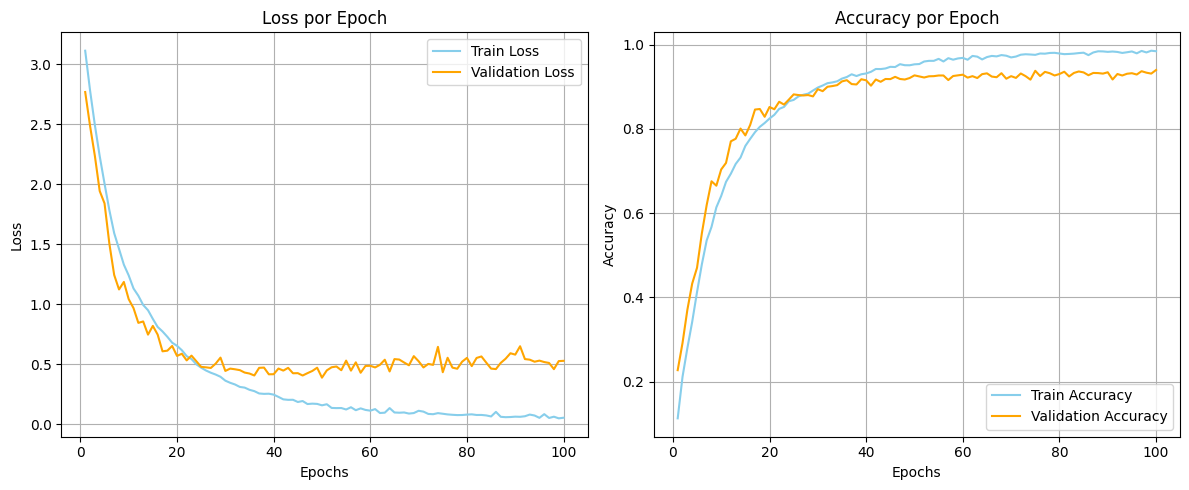

In [51]:
resumen = resumen_3

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

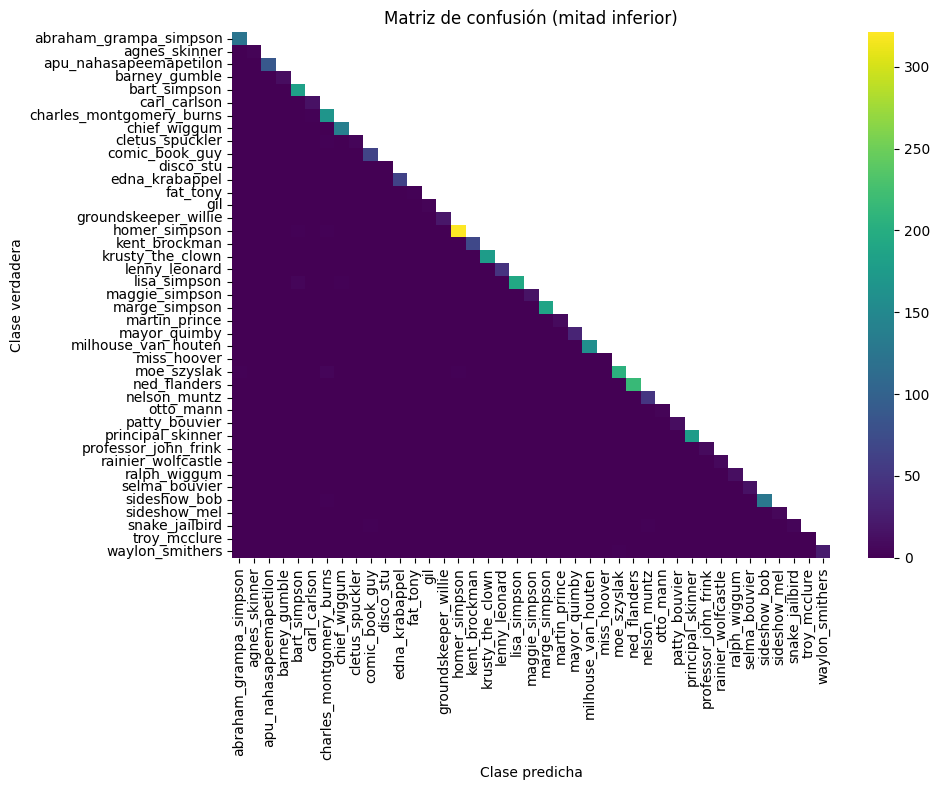

✅ Accuracy total en test: 93.51%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
groundskeeper_willie       1.000000  1.000000  1.000000     19.0
sideshow_mel               1.000000  1.000000  1.000000      6.0
ned_flanders               0.972973  0.986301  0.979592    219.0
marge_simpson              0.989474  0.969072  0.979167    194.0
krusty_the_clown           0.967033  0.972376  0.969697    181.0
principal_skinner          0.961749  0.977778  0.969697    180.0
sideshow_bob               0.976923  0.962121  0.969466    132.0
milhouse_van_houten        0.969136  0.969136  0.969136    162.0
apu_nahasapeemapetilon     0.988636  0.925532  0.956044     94.0
homer_simpson              0.933140  0.952522  0.942731    337.0
chief_wiggum               0.958042  0.925676  0.941581    148.0
edna_krabappel             0.969231  0.913043  0.940299     69.0
bart_simpson               0.963158  0.905941  0.933673    202.0
ke

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# Evalúa en test
metricas_test_3 = test_model(modelo_entrenado_3, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_3).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

In [53]:
del modelo_entrenado_3
del criterion_3
del optimizer_3

## Mejoras posibles

distintos optimizadores

distintos criterios

modelos mas complejos con mas capas

sampler balanceado en el dataloader

transfer learning

eliminar las clases con menos de X imagenes

## Modelo 4 (Sin Convolución - FCN)

### Entrenamiento

Se desarrolla una red neuronal sin convoluciones, compuesta exclusivamente por capas densas. Este modelo sirve como línea base para evaluar la importancia de las convoluciones en tareas de clasificación de imágenes. A diferencia de las CNN, la imagen se aplana antes de ser procesada, perdiendo así su estructura espacial. El modelo se organiza en un único bloque principal:

---

1. `self.model` → Compuesto por **7 capas secuenciales**, organizadas en **3 bloques funcionales**:

La imagen de entrada se transforma de su forma original `(3, 64, 64)` a un vector unidimensional de `12288` valores mediante `Flatten`. A continuación, el modelo aplica varias capas densas con activaciones y regularización:

- **Entrada y aplanado**:
  - `Flatten`: convierte la imagen `(3, 64, 64)` en un vector de `12288` elementos.

- **Bloque 1**:
  - `Linear`: 12288 → 1024 neuronas.
  - `ReLU`: función de activación no lineal.
  - `Dropout(0.5)`: desactiva aleatoriamente el 50% de las neuronas para evitar sobreajuste.

- **Bloque 2**:
  - `Linear`: 1024 → 512 neuronas.
  - `ReLU`: activa valores positivos.
  - `Dropout(0.5)`: segunda regularización.

- **Capa de salida**:
  - `Linear`: 512 → `num_classes` neuronas.
  - Produce las predicciones finales del modelo, una por clase.

---

Este modelo, al carecer de convoluciones, presenta importantes limitaciones:

- No capta la **estructura espacial** de la imagen, lo que dificulta la detección de patrones visuales.
- Su rendimiento es **significativamente inferior** al de las CNN, especialmente en tareas donde la información local es crucial.
- La regularización mediante `Dropout` ayuda, pero no compensa la pérdida de contexto espacial.

---

Este enfoque confirma que las redes totalmente conectadas no son adecuadas para problemas de visión por computador complejos, y destaca el papel fundamental de las **convoluciones** en el reconocimiento efectivo de imágenes.

In [54]:
# Definición del modelo completamente conectado (sin convoluciones)
class FullyConnectedNN(nn.Module):
    def __init__(self, num_classes):
        """
        Red neuronal totalmente conectada sin capas convolucionales.
        La entrada se aplana desde (3, 64, 64) a un vector de 12288 elementos.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                      # Aplana la imagen (3,64,64) → 12288
            nn.Linear(3 * 64 * 64, 1024),      # Capa densa: 12288 → 1024
            nn.ReLU(),                         # Activación ReLU
            nn.Dropout(0.5),                   # Regularización

            nn.Linear(1024, 512),              # Capa intermedia
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)        # Capa de salida
        )

    def forward(self, x):
        return self.model(x)

In [55]:
# Volver a ejecutarlas para tener un modelo desde cero y evitar efectos de ejecuciones previas
model_0 = FullyConnectedNN(num_classes).to(device)
criterion_0 = nn.CrossEntropyLoss()
optimizer_0 = optim.Adam(model_0.parameters(), lr=0.001)

# Entrena el modelo
modelo_entrenado_0, resumen_0 = train_model(model_0, train_loader_aug1, val_loader, criterion_0, optimizer_0, epochs=10)

Época 1/10: 100%|██████████| 458/458 [00:41<00:00, 11.00it/s]



✅ Entrenamiento — Loss: 3.1496 | Accuracy: 16.15%
🔍 Validación — Loss: 2.7609 | Accuracy: 24.27%



Época 2/10: 100%|██████████| 458/458 [00:41<00:00, 11.07it/s]



✅ Entrenamiento — Loss: 2.9819 | Accuracy: 19.55%
🔍 Validación — Loss: 2.8299 | Accuracy: 26.75%



Época 3/10: 100%|██████████| 458/458 [00:41<00:00, 11.01it/s]



✅ Entrenamiento — Loss: 2.9542 | Accuracy: 20.63%
🔍 Validación — Loss: 2.7330 | Accuracy: 25.99%



Época 4/10: 100%|██████████| 458/458 [00:41<00:00, 11.01it/s]



✅ Entrenamiento — Loss: 2.9137 | Accuracy: 21.35%
🔍 Validación — Loss: 2.7458 | Accuracy: 27.55%



Época 5/10: 100%|██████████| 458/458 [00:41<00:00, 10.99it/s]



✅ Entrenamiento — Loss: 2.9261 | Accuracy: 21.55%
🔍 Validación — Loss: 2.7746 | Accuracy: 25.70%



Época 6/10: 100%|██████████| 458/458 [00:41<00:00, 11.04it/s]



✅ Entrenamiento — Loss: 2.8995 | Accuracy: 21.46%
🔍 Validación — Loss: 2.7020 | Accuracy: 26.59%



Época 7/10: 100%|██████████| 458/458 [00:41<00:00, 11.03it/s]



✅ Entrenamiento — Loss: 2.8471 | Accuracy: 22.71%
🔍 Validación — Loss: 2.7207 | Accuracy: 24.90%



Época 8/10: 100%|██████████| 458/458 [00:41<00:00, 11.05it/s]



✅ Entrenamiento — Loss: 2.8690 | Accuracy: 22.10%
🔍 Validación — Loss: 2.7074 | Accuracy: 27.48%



Época 9/10: 100%|██████████| 458/458 [00:41<00:00, 10.97it/s]



✅ Entrenamiento — Loss: 2.8320 | Accuracy: 22.95%
🔍 Validación — Loss: 2.6481 | Accuracy: 27.36%



Época 10/10: 100%|██████████| 458/458 [00:41<00:00, 11.06it/s]



✅ Entrenamiento — Loss: 2.8097 | Accuracy: 23.25%
🔍 Validación — Loss: 2.6790 | Accuracy: 26.11%



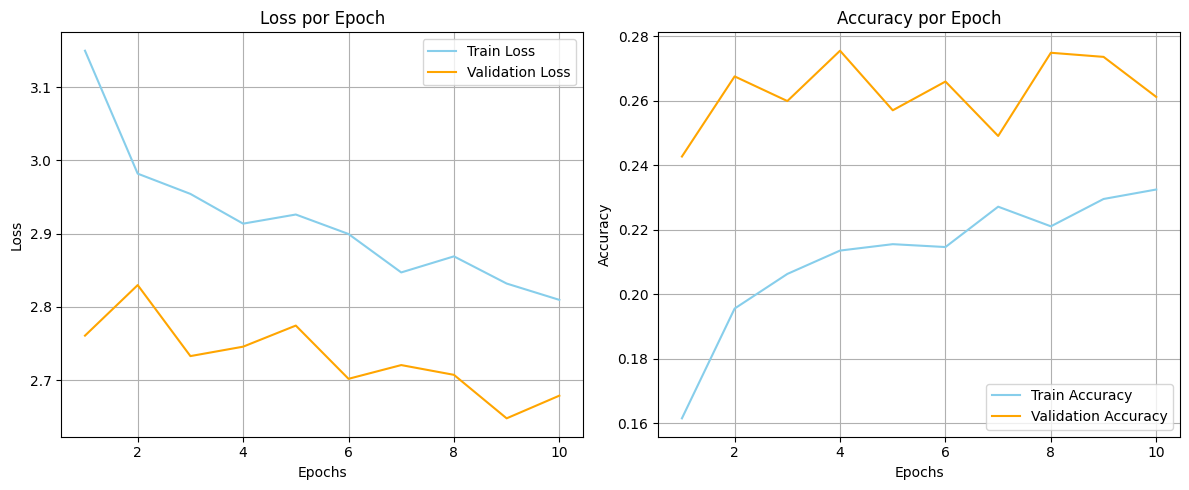

In [56]:
resumen = resumen_0

# Crear figura con los resumenes
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(resumen['epoch'], resumen['train_loss'], label='Train Loss', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss por Epoch')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(resumen['epoch'], resumen['train_acc'], label='Train Accuracy', color='skyblue')
plt.plot(resumen['epoch'], resumen['val_acc'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy por Epoch')
plt.legend()
plt.grid(True)

# Ajustar espaciado y mostrar
plt.tight_layout()
plt.show()

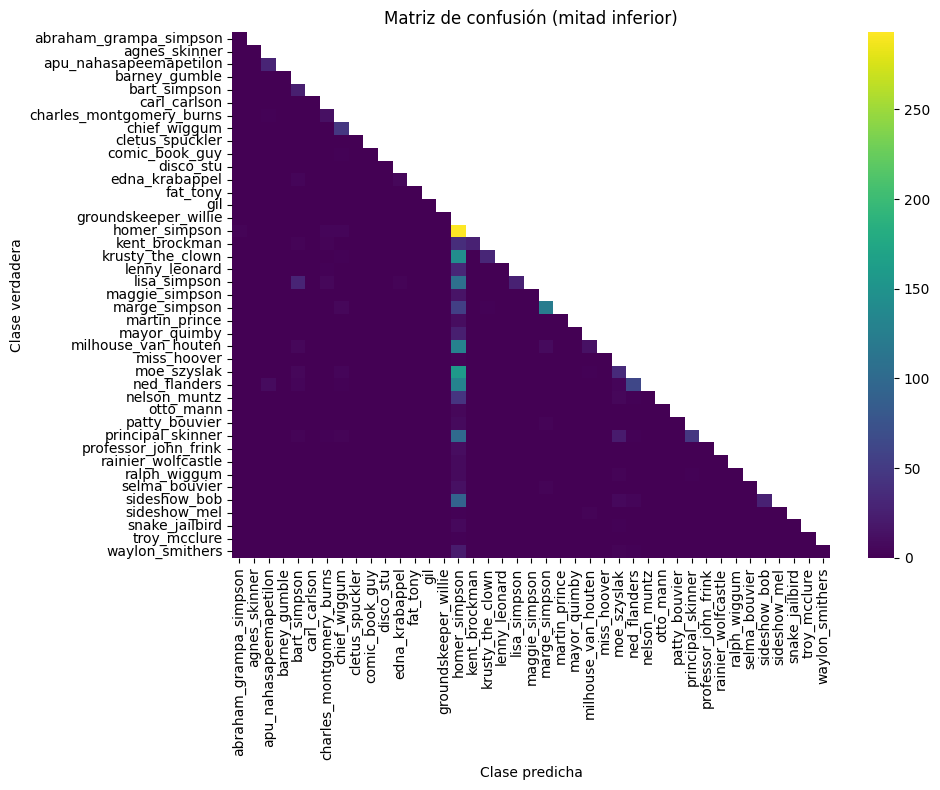

✅ Accuracy total en test: 25.36%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
marge_simpson              0.762500  0.628866  0.689266    194.0
kent_brockman              1.000000  0.360000  0.529412     75.0
apu_nahasapeemapetilon     0.707317  0.308511  0.429630     94.0
chief_wiggum               0.528736  0.310811  0.391489    148.0
ned_flanders               0.416107  0.283105  0.336957    219.0
sideshow_bob               0.870968  0.204545  0.331288    132.0
principal_skinner          0.348485  0.255556  0.294872    180.0
krusty_the_clown           0.756098  0.171271  0.279279    181.0
homer_simpson              0.142648  0.869436  0.245086    337.0
lisa_simpson               0.473684  0.132353  0.206897    204.0
moe_szyslak                0.179487  0.160550  0.169492    218.0
bart_simpson               0.265957  0.123762  0.168919    202.0
milhouse_van_houten        0.342105  0.080247  0.130000    162.0
ed

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
# Evalúa en test
metricas_test_0 = test_model(modelo_entrenado_0, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_0).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

In [58]:
del modelo_entrenado_0
del criterion_0
del optimizer_0